In [1]:
import os
import sys
import random
import pickle

import numpy as np
import pandas as pd
import scipy
import scipy.sparse as sp_sparse
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns

import scanpy as sc
import anndata as ad

import torch
import torch.nn as nn
import torch.nn.functional as F

import gensim
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

from STdGCN import *
from STdGCN.utils import *
from STdGCN.autoencoder import *
from STdGCN.adjacency_matrix import *
# from STdGCN.GCN import *
from STdGCN.visualization import *
from STdGCN.utility.IO import read_10X_h5, read_count, write_10X_h5
from STdGCN.ModelEvaluate import *
from STdGCN.ModelTrain import ModelSelect

from typing import Optional, Union, List
from torch_geometric.nn import GATConv
from torch_geometric.nn import knn_graph, radius_graph
from torch_geometric.utils import to_undirected

import warnings
warnings.filterwarnings("ignore")
sys.path.append(os.getcwd())


/data/lyx/software/anaconda3/envs/pyG01/lib/python3.8/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /data/lyx/software/anaconda3/envs/pyG01/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(


In [2]:
# import torch
# import numpy as np
# import pandas as pd
# import scanpy as sc
# import scipy.sparse as sp
# from sklearn.neighbors import KDTree, DistanceMetric
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.neighbors import NearestNeighbors
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from sklearn.neighbors import KDTree
from sklearn.metrics import DistanceMetric
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors




def find_mutual_nn(data1, 
                   data2, 
                   dist_method, 
                   k1, 
                   k2, 
                  ):
    if dist_method == 'cosine':
        cos_sim1 = cosine_similarity(data1, data2)
        cos_sim2 = cosine_similarity(data2, data1)
        k_index_1 = torch.topk(torch.tensor(cos_sim2), k=k2, dim=1)[1]
        k_index_2 = torch.topk(torch.tensor(cos_sim1), k=k1, dim=1)[1]
    else:
        dist = DistanceMetric.get_metric(dist_method)
        k_index_1 = KDTree(data1, metric=dist).query(data2, k=k2, return_distance=False)
        k_index_2 = KDTree(data2, metric=dist).query(data1, k=k1, return_distance=False)
    mutual_1 = []
    mutual_2 = []
    # mutual = []
    for index_2 in range(data2.shape[0]):
        for index_1 in k_index_1[index_2]:
            if index_2 in k_index_2[index_1]: 
                mutual_1.append(index_1)
                mutual_2.append(index_2)
                # mutual.append([index_1, index_2])
    return torch.tensor([mutual_1, mutual_2])


In [3]:
# prefix = 'zebrafish'
# res = 50
# idx1 = 'time12_slice8'
# dataset = '{0}_{1}'.format(prefix,idx1)

pseudo_spot_paras = {
    'spot_num': 10000,
    'min_cell_num_in_spot': 5,
    'max_cell_num_in_spot': 15,
    'generation_method': 'celltype',
    'max_cell_types_in_spot': 4,   
}

# paths = {
#     'sc_path': './benchmark_data/stereo_seq/zebrafish/sc_data/{0}_{1}_sc_data.tsv'.format(prefix,idx1),
#     'sc_label_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/{0}_{1}_sc_label.tsv'.format(prefix,idx1),
#     'ST_path': './benchmark_data/stereo_seq/zebrafish/ST_data/{0}_{1}_data_{2}.tsv'.format(prefix,res,idx1),
#     'coordinates_path' : './benchmark_data/stereo_seq/zebrafish/ST_data/{0}_{1}_coordinates_{2}.csv'.format(prefix,res,idx1),
#     'groundtruth_path' : './benchmark_data/stereo_seq/zebrafish/ST_data/{0}_{1}_ground_truth_{2}.tsv'.format(prefix,res,idx1),
#     'pseudo_spots_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/pseudo_spots/pseudo_ST_{0}_{1}_{2}_{3}.pkl'.format(pseudo_spot_paras['spot_num'], pseudo_spot_paras['min_cell_num_in_spot'], pseudo_spot_paras['max_cell_num_in_spot'], pseudo_spot_paras['max_cell_types_in_spot']),
#     'topic_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/topic',
#     'output_path' : './output_stereo/{}_{}/GAT'.format(prefix, idx1), 
#     # 'predict_path':'./output_MERFISH/ID1/Bregma0.01/predict_result_{0}_{1}.csv'.format(idx2, pseudo_spot_paras['spot_num']),
#     'metric_path' : './benchmark/metric_TopicGAT_edge_stereo.tsv',
# }

find_marker_genes_paras = {
    'preprocess': True,
    'normalize': True,
    'log': True,
    'highly_variable_genes': False,
    'highly_variable_gene_num': None,
    'regress_out': False,
    'PCA_components': 30, 
    'marker_gene_method': 'logreg',
    'top_gene_per_type': 100,
    'filter_wilcoxon_marker_genes': True,
    'pvals_adj_threshold': 0.10,
    'log_fold_change_threshold': 1,
    'min_within_group_fraction_threshold': None,
    'max_between_group_fraction_threshold': None,
}

data_normalization_paras = {
    'normalize': True, 
    'log': True, 
    'scale': False,
}

integration_for_adj_paras = {
    'batch_removal_method': None, 
    'dim': 30, 
    'dimensionality_reduction_method': 'PCA',
    'scale': True,
}

inter_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine', 
    'corr_dist_neighbors': 20, 
}

real_intra_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine',  
    'corr_dist_neighbors': 10,
    'PCA_dimensionality_reduction': False,
    'dim': 50,
}

pseudo_intra_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine', 
    'corr_dist_neighbors': 20,
    'PCA_dimensionality_reduction': False,
    'dim': 50,
}

spatial_adj_paras = {
    'link_method': 'soft', 
    'space_dist_threshold': 2,
}

integration_for_feature_paras = {
    'batch_removal_method': None, 
    'dimensionality_reduction_method': None, 
    'dim': 80,
    'scale': True,
}

GAT_paras = {
    'epoch_n': 3000,
    'dim': 80,
    'common_hid_layers_num': 1,
    'fcnn_hid_layers_num': 1,
    'dropout': 0,
    'learning_rate_SGD': 2e-1,
    'weight_decay_SGD': 3e-4,
    'momentum': 0.9,
    'dampening': 0,
    'nesterov': True,
    'early_stopping_patience': 200,
    'clip_grad_max_norm': 1,
    #'LambdaLR_scheduler_coefficient': 0.997,
    'print_loss_epoch_step': 5,
}


In [21]:
# #  设置随机数种子
# def setup_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True

    
# def makedirs(path):
#     if not os.path.isdir(path): # os.path.isdir只会判断是不是路径，给文件的路径会输出false；os.path.exists会判断文件是否存在
#         os.makedirs(path) # 只会创建路径
        
        
# def run_TopicGAT_edge( paths,
#                        find_marker_genes_paras,
#                        pseudo_spot_paras,
#                        data_normalization_paras,
#                        integration_for_adj_paras,
#                        inter_exp_adj_paras,
#                        spatial_adj_paras,
#                        real_intra_exp_adj_paras,
#                        pseudo_intra_exp_adj_paras,
#                        integration_for_feature_paras,
#                        GAT_paras,
#                        load_test_groundtruth = False,
#                        use_marker_genes = True,
#                        external_genes = False,
#                        generate_new_pseudo_spots = False,
#                        fraction_pie_plot = False,
#                        cell_type_distribution_plot = True,
#                        n_jobs = 24,
#                        GCN_device = 'cpu',
#                        seed = 10,
#                        is_add_edge = True,
#                        dataset = dataset
#                     ):
#     use_topic = False
#     sc_path = paths['sc_path']
#     sc_label_path =paths['sc_label_path']
#     ST_path = paths['ST_path']
#     coordinates_path = paths['coordinates_path']
#     groundtruth_path = paths['groundtruth_path']
#     pseudo_spots_path = paths['pseudo_spots_path'] 
#     topic_path = paths['topic_path']
#     output_path = paths['output_path']
#     makedirs(topic_path)
#     makedirs(output_path)
    
#     if is_add_edge == False:
#         predict_path = os.path.join(paths['output_path'], 'TopicGAT_predict_result_'+dataset+'_{}_{}.tsv'.format(pseudo_spot_paras['spot_num'], seed))
#     else:
#         predict_path = os.path.join(paths['output_path'], 'TopicGAT_edge_predict_result_'+dataset+'_{}_{}.tsv'.format(pseudo_spot_paras['spot_num'], seed))
#     metric_path = paths['metric_path']

#     setup_seed(seed)
#     # plt.rcParams['font.sans-serif'] = ['Arial']
#     plt.rcParams['font.sans-serif'] = ['SimHei']
#     mpl.rcParams['axes.unicode_minus'] = False
#     sc_adata = sc.read_csv(sc_path,delimiter='\t')
#     st_adata = sc.read_csv(ST_path, delimiter='\t')
#     sc.pp.filter_genes(st_adata, min_cells=3)
#     st_adata.raw = st_adata
#     sc.pp.normalize_total(st_adata, target_sum=1e4)
#     sc.pp.log1p(st_adata) 
#     file_name = dataset
#     sc.pp.highly_variable_genes(st_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#     sc.pl.highly_variable_genes(st_adata,save='_'+file_name+'_scRNA_hvg.svg')
#     sc.pp.scale(st_adata, max_value=10)
#     sc.tl.pca(st_adata, svd_solver='arpack')
#     # sc.pl.pca_variance_ratio(st_adata, log=True)
#     st_adata.obsm['X_pca'].shape
#     sc.pp.neighbors(st_adata, n_neighbors=4, n_pcs=15)
#     sc.tl.umap(st_adata)
#     sc.tl.leiden(st_adata,resolution=0.2)
#     sc.pl.umap(st_adata, color='leiden',save='umap.pdf')

#     # 获取聚类的类别，作为domain的id，第一列位real-spot的名字，第二列位domain类别
#     domain_class = st_adata.obs['leiden']
    
#     sc_label = pd.read_table(sc_label_path, sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
#     sc_label.columns = ['cell_type']
#     sc_adata.obs['cell_type'] = sc_label['cell_type'].values

#     cell_type_num = len(sc_adata.obs['cell_type'].unique())
#     cell_types = sc_adata.obs['cell_type'].unique()

#     word_to_idx_celltype = {word: i for i, word in enumerate(cell_types)}
#     idx_to_word_celltype = {i: word for i, word in enumerate(cell_types)}

#     celltype_idx = [word_to_idx_celltype[w] for w in sc_adata.obs['cell_type']]
#     sc_adata.obs['cell_type_idx'] = celltype_idx
#     sc_adata.obs['cell_type'].value_counts()

#     if use_marker_genes == True:
#         if external_genes == True:
#             with open(output_path+"/marker_genes.tsv", 'r') as f:
#                 selected_genes = [line.rstrip('\n') for line in f]
#         else:
#             selected_genes, cell_type_marker_genes = find_marker_genes(sc_adata,
#                                                                       preprocess = find_marker_genes_paras['preprocess'],
#                                                                       highly_variable_genes = find_marker_genes_paras['highly_variable_genes'],
#                                                                       PCA_components = find_marker_genes_paras['PCA_components'], 
#                                                                       filter_wilcoxon_marker_genes = find_marker_genes_paras['filter_wilcoxon_marker_genes'], 
#                                                                       marker_gene_method = find_marker_genes_paras['marker_gene_method'],
#                                                                       pvals_adj_threshold = find_marker_genes_paras['pvals_adj_threshold'],
#                                                                       log_fold_change_threshold = find_marker_genes_paras['log_fold_change_threshold'],
#                                                                       min_within_group_fraction_threshold = find_marker_genes_paras['min_within_group_fraction_threshold'],
#                                                                       max_between_group_fraction_threshold = find_marker_genes_paras['max_between_group_fraction_threshold'],
#                                                                       top_gene_per_type = find_marker_genes_paras['top_gene_per_type'])
#             with open(output_path+"/marker_genes.tsv", 'w') as f:
#                 for gene in selected_genes:
#                     f.write(str(gene) + '\n')
#     print("{} genes have been selected as marker genes.".format(len(selected_genes)))

# #     generate_new_pseudo_spots = False
#     # if generate_new_pseudo_spots == True:
#     #     pseudo_adata = pseudo_spot_generation(sc_adata,
#     #                                           idx_to_word_celltype,
#     #                                           spot_num = pseudo_spot_simulation_paras['spot_num'],
#     #                                           min_cell_number_in_spot = pseudo_spot_simulation_paras['min_cell_num_in_spot'],
#     #                                           max_cell_number_in_spot = pseudo_spot_simulation_paras['max_cell_num_in_spot'],
#     #                                           max_cell_types_in_spot = pseudo_spot_simulation_paras['max_cell_types_in_spot'],
#     #                                           generation_method = pseudo_spot_simulation_paras['generation_method'],
#     #                                           n_jobs = n_jobs
#     #                                           )
#     #     data_file = open(output_path+'/pseudo_ST.pkl','wb')
#     #     pickle.dump(pseudo_adata, data_file)
#     #     data_file.close()
#     # else:
#     #     data_file = open(output_path+'/pseudo_ST_8_12_4.pkl','rb')
#     #     pseudo_adata = pickle.load(data_file)
#     #     data_file.close()
#     data_file = open(pseudo_spots_path,'rb')
#     pseudo_adata = pickle.load(data_file)
    
#     ST_adata = sc.read_csv(ST_path, delimiter='\t')
#     ST_coor = pd.read_table(coordinates_path, sep = ',', header = 0, index_col = 0, encoding = "utf-8")
#     ST_adata.obs['coor_X'] = ST_coor['x']
#     ST_adata.obs['coor_Y'] = ST_coor['y']
#     if load_test_groundtruth == True:
#         ST_groundtruth = pd.read_table(groundtruth_path, sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
#         for i in cell_types:
#             ST_adata.obs[i] = ST_groundtruth[i]

#     ST_genes = ST_adata.var.index.values
#     pseudo_genes = pseudo_adata.var.index.values
#     common_genes = set(ST_genes).intersection(set(pseudo_genes))
#     ST_adata_filter = ST_adata[:,list(common_genes)]
#     pseudo_adata_filter = pseudo_adata[:,list(common_genes)]
    
#     adata1 =  ST_preprocess(  ST_adata_filter, 
#                              normalize = data_normalization_paras['normalize'], 
#                              log = data_normalization_paras['log'], 
#                              scale = data_normalization_paras['scale'],
#                             )
#     selected_genes=list(set(adata1.var_names) &set(selected_genes))
    
#     ST_adata_filter_norm = adata1[:,selected_genes]
#     try:
#         try:
#             ST_adata_filter_norm.obs.insert(0, 'cell_num', ST_adata_filter.obs['cell_num'])
#         except:
#             ST_adata_filter_norm.obs['cell_num'] = ST_adata_filter.obs['cell_num']
#     except:
#         ST_adata_filter_norm.obs.insert(0, 'cell_num', [0]*ST_adata_filter_norm.obs.shape[0])
#     for i in cell_types:
#         try:
#             ST_adata_filter_norm.obs[i] = ST_adata_filter.obs[i]
#         except:
#             ST_adata_filter_norm.obs[i] = [0]*ST_adata_filter_norm.obs.shape[0]
#     try:
#         ST_adata_filter_norm.obs['cell_type_num'] = (ST_adata_filter_norm.obs[cell_types]>0).sum(axis=1)
#     except:
#         ST_adata_filter_norm.obs['cell_type_num'] = [0]*ST_adata_filter_norm.obs.shape[0]
        
#     pseudo_adata_norm = ST_preprocess(pseudo_adata_filter, 
#                                       normalize = data_normalization_paras['normalize'], 
#                                       log = data_normalization_paras['log'], 
#                                       scale = data_normalization_paras['scale'],
#                                      )[:,selected_genes]

#     pseudo_adata_norm.obs['cell_type_num'] = (pseudo_adata_norm.obs[cell_types]>0).sum(axis=1)

#     ST_integration = data_integration(ST_adata_filter_norm, 
#                                       pseudo_adata_norm, 
#                                       batch_removal_method = integration_for_adj_paras['batch_removal_method'], 
#                                       dim = min(integration_for_adj_paras['dim'], int(ST_adata_filter_norm.shape[1]/2)), 
#                                       dimensionality_reduction_method=integration_for_adj_paras['dimensionality_reduction_method'],
#                                       scale=integration_for_adj_paras['scale'],
#                                       cpu_num=n_jobs,
#                                       AE_device=GCN_device
#                                       )

#     def LDA(sc_corpus, ntopics, genes_dict, genes_shared, cell_gene_list, sc_count_cells, cell_celltype_list, model_dir):
#         lda = LdaModel(corpus = sc_corpus, num_topics = ntopics, id2word = genes_dict)
#         if not os.path.exists(model_dir):
#             os.makedirs(model_dir)
#         model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics))
#         lda.save(model_file)
#         # compute the coherence
#         cm = CoherenceModel(model = lda, corpus = sc_corpus, coherence='u_mass')
#         umass_coherence = cm.get_coherence()
#         cm = CoherenceModel(model = lda, corpus = sc_corpus, texts = cell_gene_list, coherence='c_v')
#         cv_coherence = cm.get_coherence()
#         # save the topic-cell matrix
#         topic_cell = lda.get_document_topics(sc_corpus)
#         topic_cell_mat = gensim.matutils.corpus2csc(topic_cell)
#         topic_cell_file = os.path.join(model_dir, "topic_cell_mat_%s.npz" %(ntopics))
#         topic_cell_df_file = os.path.join(model_dir, "topic_cell_mat_%s.txt" %(ntopics))
#         scipy.sparse.save_npz(topic_cell_file, topic_cell_mat)
#         topic_cell_df = pd.DataFrame(topic_cell_mat.todense(), 
#             index = ["Topic %s" %i for i in range(1, 1 + topic_cell_mat.shape[0])], 
#             columns = sc_count_cells)
#         topic_cell_df.to_csv(topic_cell_df_file, sep = "\t", index = True, header = True)
#         # save the gene-topic matrix
#         topic_gene_mat_list = lda.get_topics()
#         topic_gene_mat = np.array(topic_gene_mat_list)
#         gene_topic_mat = topic_gene_mat.transpose()
#         gene_topic_mat_list = gene_topic_mat.tolist()
#         gene_topic_file = os.path.join(model_dir, "gene_topic_mat_%s.txt" %(ntopics))
#         gene_topic_out = open(gene_topic_file, "w")
#         gene_topic_out.write("\t".join(["Topic%s" %i for i in range(1, ntopics + 1)]) + "\n")
#         for i in range(len(gene_topic_mat_list)):
#             gene_topic_out.write(genes_shared[i] + "\t" + "\t".join([str(j) for j in gene_topic_mat_list[i]]) + "\n")
#         gene_topic_out.close()
#         # convert topic_cell_mat to topic_celltype_mat
#         celltype_topic_dict = {}
#         celltype_num_dict = {}
#         celltypes = sorted(list(set(cell_celltype_list)))
#         for celltype in celltypes:
#             celltype_topic_dict[celltype] = [0]*ntopics
#             celltype_num_dict[celltype] = 0
#         for i in range(topic_cell_mat.shape[1]):
#             cell_celltype = cell_celltype_list[i]
#             celltype_topic_dict[cell_celltype] = [celltype_topic_dict[cell_celltype][j] + topic_cell_mat[j,i] for j in range(topic_cell_mat.shape[0])]
#             celltype_num_dict[cell_celltype] = celltype_num_dict[cell_celltype] + 1
#         celltype_topic_mean_dict = {}
#         for celltype in celltypes:
#             celltype_topic_mean_dict[celltype] = [i/celltype_num_dict[celltype] for i in celltype_topic_dict[celltype]]
#         topic_celltype_df = pd.DataFrame(data = celltype_topic_mean_dict)
#         topic_celltype_file = os.path.join(model_dir,"topic_celltype_mat_%s.txt" %(ntopics))
#         topic_celltype_df.to_csv(topic_celltype_file, sep="\t")
#         # return results
#         res_dict = {"coherence": [umass_coherence, cv_coherence], 
#         "topic_cell_mat": topic_cell_mat, 
#         "topic_celltype_df": topic_celltype_df,
#         "celltype_num_dict": celltype_num_dict}
#         return(res_dict)

#     def scLDA(sc_count_mat, sc_count_genes, sc_count_cells, cell_celltype_dict,
#               st_count_mat, st_count_genes, st_count_spots,
#               normalize, gene_use, ntopics_list, out_dir):
#         sc_count_genes_array = np.array(sc_count_genes)
#         sc_count_genes_sorter = np.argsort(sc_count_genes_array)
#         if normalize:
#             sc_count_mat = StandardScaler(with_mean=False).fit_transform(sc_count_mat.transpose()).transpose()
#         if gene_use == "All":
#             genes_shared = list(set(st_count_genes) & set(sc_count_genes))
#         else:
#             genes_shared = list(set(st_count_genes) & set(sc_count_genes) & set(gene_use))
#         genes_shared = sorted(genes_shared)
#         genes_shared_array = np.array(genes_shared)
#         genes_shared_index = sc_count_genes_sorter[np.searchsorted(sc_count_genes_array, genes_shared_array, sorter = sc_count_genes_sorter)]
#         sc_count_mat_use = sc_count_mat[genes_shared_index,:]
#         cell_gene_list = []
#         sc_count_mat_use_nonzero = sc_count_mat_use.nonzero()
#         for i in range(sc_count_mat_use.shape[1]):
#             gene_ind = sc_count_mat_use_nonzero[0][sc_count_mat_use_nonzero[1] == i]
#             genes = genes_shared_array[gene_ind].tolist()
#             cell_gene_list.append(genes)
#             # evaluate the model
#         # construct single-cell gene corpus
#         sc_corpus = gensim.matutils.Sparse2Corpus(sc_count_mat_use)
#         genes_dict = Dictionary([genes_shared])
#         genes_dict_file = os.path.join(out_dir, "Gene_dict.txt")
#         genes_dict.save_as_text(genes_dict_file)
#         cell_celltype_list = []
#         for i in range(len(sc_count_cells)):
#             cell_celltype = cell_celltype_dict[sc_count_cells[i]]
#             cell_celltype_list.append(cell_celltype)
#         print("Selecting the optimal model.")
#         model_selection_res = ModelSelect(sc_corpus = sc_corpus, genes_dict = genes_dict, genes_shared = genes_shared,
#             ntopics_list = ntopics_list, cell_gene_list = cell_gene_list, sc_count_cells = sc_count_cells, 
#             cell_celltype_list = cell_celltype_list, out_dir = out_dir)
#         model_selected = model_selection_res["model"]
#         ntopics_selected = model_selection_res["ntopics"]

#         return({"genes_dict": genes_dict, "model_selected": model_selected, "ntopics_selected": ntopics_selected})

#     celltypes = set(list(sc_adata.obs['cell_type']))
#     celltypes
#     cell_celltype_dict = {}
#     for index_ in sc_adata.obs['cell_type'].index:
#         cell_celltype_dict[index_] = sc_adata.obs['cell_type'][index_]
#     list(cell_celltype_dict.values())[:3]

#     sc_count_scale_mat = scipy.sparse.csc_matrix(sc_adata.X.T) #需要使用稀疏格式 csc
#     sc_count_genes = selected_genes
#     sc_count_cells = list(sc_adata.obs['cell_type'].index)
#     # cell_celltype_dict
#     st_count_mat = scipy.sparse.csc_matrix(ST_adata_filter_norm.X.T)
#     st_count_genes = selected_genes
#     st_count_spots = ST_adata_filter_norm.obs['cell_num'].index.tolist()
#     normalize = None # 需要调整
#     gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？
#     ntopics_list= [] # 可以设置为一个包含topic数目的列表，比如[4,5,6]；如果设置为[]，会自动从
#                     # ntopics_list = list(range(len(celltypes), 3*len(celltypes)+1))范围内选取效果最好的主题数目
#     # out_dir = "./topic_output"
#     out_dir = topic_path

#     celltypes = set(list(sc_adata.obs['cell_type']))
#     #ntopics_list = list(range(20, 3*len(celltypes)+1))
#     if not ntopics_list:
#         ntopics_list = list(range(len(celltypes), 3*len(celltypes)+1))

#     # 如果在topic_path下没有存best_model_para.pickle，则从新生成
#     # train_new_topic_model = False
#     if os.path.exists(os.path.join(out_dir, "best_model_para.pickle")):
#         train_new_topic_model = False
#     else:
#         train_new_topic_model = True

#     if train_new_topic_model == True:
#         #  训练新的主题模型
#         print("Training topic model...")
#         lda_res = scLDA(sc_count_scale_mat, sc_count_genes, sc_count_cells, cell_celltype_dict,
#                         st_count_mat, st_count_genes, st_count_spots,
#                         normalize, gene_use, ntopics_list, out_dir)
#         genes_dict = lda_res["genes_dict"]
#         model_selected = lda_res["model_selected"]
#         ntopics_selected = lda_res["ntopics_selected"]
#         model_dir = os.path.join(out_dir, "model")
#         with open(os.path.join(out_dir, "best_model_para.pickle"), "wb") as file:
#             pickle.dump([genes_dict, model_selected, ntopics_selected, model_dir], file)
#     else:
#         # 直接加载训练好的topic 模型
#         with open(os.path.join(out_dir, "best_model_para.pickle"), "rb") as file:
#             best_model_para = pickle.load(file)
#         genes_dict = best_model_para[0]
#         model_selected = best_model_para[1]
#         ntopics_selected = best_model_para[2]
#         model_dir = best_model_para[3]

#     # [genes_dict, model_selected, ntopics_selected, model_dir]

#     # 从SpatialDeconvolve函数修改得到
#     def GetRealSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, ntopics_selected, normalize, out_dir, model_dir, out_prefix):
#         st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
#         st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
#         if normalize:
#             st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
#         genes_dict_token2id = genes_dict.token2id
#         genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
#         genes_shared = sorted(genes_shared)
#         genes_shared_array = np.array(genes_shared)
#         genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
#         st_count_mat_use = st_count_mat[genes_shared_index,:]
#         st_corpus = []
#         for i in range(st_count_mat_use.shape[1]):
#         # for i in range(2):
#             st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
#             # print(st_genes_nonzero_index[0:10])
#             st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
#             st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
#             # print(st_genes_nonzero_index_corpus[0:10])
#             st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
#             st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
#         topic_spot_file = os.path.join(out_dir, "%s_topic_real_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
#         topic_spot_df_file = os.path.join(out_dir, "%s_topic_real_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

#         model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
#         lda = LdaModel.load(model_file)
#         topic_spot = lda.get_document_topics(st_corpus)
#         topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
#         scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
#         topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
#             index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
#             columns = st_count_spots)
#         topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)

#         # 若存在topic_spot_mat，不在重新生成
#         # if os.path.exists(topic_spot_file):
#         #     topic_spot_mat = scipy.sparse.load_npz(topic_spot_file)
#         # else:
#         #     model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
#         #     lda = LdaModel.load(model_file)
#         #     topic_spot = lda.get_document_topics(st_corpus)
#         #     topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
#         #     scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
#         #     topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
#         #         index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
#         #         columns = st_count_spots)
#         #     topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)

#         # 这是stride中用于比例分解的代码
#         # if model_selected == "Raw":
#         #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveRaw(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
#         # if model_selected == "Norm":
#         #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveNorm(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
#         # if model_selected == "NormBySD":
#         #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveNormBySD(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
#         # if model_selected == "Bayes":
#         #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveBayes(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
#         # if model_selected == "BayesNorm":
#         #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveBayesNorm(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
#         # spot_celltype_array_norm_df_file = os.path.join(out_dir, "%s_spot_celltype_frac.txt" %(out_prefix))
#         # spot_celltype_array_norm_df.to_csv(spot_celltype_array_norm_df_file, sep = "\t")
#         # return(spot_celltype_array_norm_df)
#         return topic_spot_df

#     def GetPseudoSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, ntopics_selected, normalize, out_dir, model_dir, out_prefix):
#         st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
#         st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
#         if normalize:
#             st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
#         genes_dict_token2id = genes_dict.token2id
#         genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
#         genes_shared = sorted(genes_shared)
#         genes_shared_array = np.array(genes_shared)
#         genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
#         st_count_mat_use = st_count_mat[genes_shared_index,:]
#         st_corpus = []
#         for i in range(st_count_mat_use.shape[1]):
#         # for i in range(2):
#             st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
#             # print(st_genes_nonzero_index[0:10])
#             st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
#             st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
#             # print(st_genes_nonzero_index_corpus[0:10])
#             st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
#             st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
#         topic_spot_file = os.path.join(out_dir, "%s_topic_pseudo_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
#         topic_spot_df_file = os.path.join(out_dir, "%s_topic_pseudo_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

#         model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
#         lda = LdaModel.load(model_file)
#         topic_spot = lda.get_document_topics(st_corpus)
#         topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
#         scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
#         topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
#             index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
#             columns = st_count_spots)
#         topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)
#         return topic_spot_df

#     def GetIntegrationSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, ntopics_selected, normalize, out_dir, model_dir, out_prefix):
#         st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
#         st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
#         if normalize:
#             st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
#         genes_dict_token2id = genes_dict.token2id
#         genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
#         genes_shared = sorted(genes_shared)
#         genes_shared_array = np.array(genes_shared)
#         genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
#         st_count_mat_use = st_count_mat[genes_shared_index,:]
#         st_corpus = []
#         for i in range(st_count_mat_use.shape[1]):
#         # for i in range(2):
#             st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
#             # print(st_genes_nonzero_index[0:10])
#             st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
#             st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
#             # print(st_genes_nonzero_index_corpus[0:10])
#             st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
#             st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
#         topic_spot_file = os.path.join(out_dir, "%s_topic_integration_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
#         topic_spot_df_file = os.path.join(out_dir, "%s_topic_integration_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

#         model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
#         lda = LdaModel.load(model_file)
#         topic_spot = lda.get_document_topics(st_corpus)
#         topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
#         scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
#         topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
#             index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
#             columns = st_count_spots)
#         topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)
#         return topic_spot_df

#     st_count_mat = scipy.sparse.csc_matrix(ST_adata_filter_norm.X.T)
#     st_count_genes = selected_genes
#     st_count_spots = ST_adata_filter_norm.obs['cell_num'].index.tolist()
#     normalize = None # 需要调整
#     gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？
#     out_dir = topic_path
#     out_prefix = dataset

#     topic_real_spot_df = GetRealSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, 
#                                           ntopics_selected, normalize, out_dir, model_dir, out_prefix)

#     # 为什么选择27个topics，而topic_real_spot_df只有26个topics
#     st_count_mat = scipy.sparse.csc_matrix(ST_adata_filter_norm.X.T)
#     st_count_genes = selected_genes
#     st_count_spots = ST_adata_filter_norm.obs['cell_num'].index.tolist()
#     normalize = None # 需要调整
#     gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？
#     ntopics_list= [] # 将来作为输入参数
#     out_prefix = dataset

#     st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
#     st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
#     if normalize:
#         st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
#     genes_dict_token2id = genes_dict.token2id
#     genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
#     genes_shared = sorted(genes_shared)
#     genes_shared_array = np.array(genes_shared)
#     genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
#     st_count_mat_use = st_count_mat[genes_shared_index,:]
#     st_corpus = []
#     for i in range(st_count_mat_use.shape[1]):
#         st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
#         st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
#         st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
#         st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
#         st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
#     topic_spot_file = os.path.join(out_dir, "%s_topic_real_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
#     topic_spot_df_file = os.path.join(out_dir, "%s_topic_real_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

#     model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))

#     lda = LdaModel.load(model_file)
#     topic_spot = lda.get_document_topics(st_corpus)
#     # 这里预测的topic数目和输入的ntopics_selected不一致，为什么呢？
#     topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
#     scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
#     topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
#         index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
#         columns = st_count_spots)
#     topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)

#     st_count_mat = scipy.sparse.csc_matrix(pseudo_adata_norm.X.T)
#     st_count_genes = selected_genes
#     st_count_spots = pseudo_adata_norm.obs['cell_num'].index.tolist()
#     normalize = None # 需要调整
#     gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？

#     topic_pseudo_spot_df = GetPseudoSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, 
#                                           ntopics_selected, normalize, out_dir, model_dir, out_prefix)

#     topic_pseudo_spot_df = topic_pseudo_spot_df.loc[topic_real_spot_df.index]

#     # if topic_real_spot_df.shape[0] != topic_pseudo_spot_df.shape[0]:
#     #     topic_pseudo_spot_df = topic_pseudo_spot_df.loc[topic_real_spot_df.index]
#     #  需要处理预测的topic数目和输入的ntopics_selected 不一致的问题
#     if topic_real_spot_df.shape[0] == topic_pseudo_spot_df.shape[0]:
#         # bad_topic_count += 1
        

#         ST_integration_topic = pd.concat([ST_integration.iloc[:,:3],pd.concat([topic_real_spot_df.T,topic_pseudo_spot_df.T], axis=0)], axis=1)
#         ST_adata_filter_norm_topic=ad.AnnData(topic_real_spot_df.T.values,obs=ST_adata_filter_norm.obs)
#         pseudo_adata_norm_topic=ad.AnnData(topic_pseudo_spot_df.T.values,obs=pseudo_adata_norm.obs)

#         # 后续创建表达邻近图的函数，只用了.X
#         def intra_exp_adj(adata, 
#                           find_neighbor_method='KNN', 
#                           dist_method='euclidean', 
#                           PCA_dimensionality_reduction=True, 
#                           dim=50, 
#                           corr_dist_neighbors=10, 
#                           ):

#             ST_exp = adata.copy()

#             sc.pp.scale(ST_exp, max_value=None, zero_center=True)
#             if PCA_dimensionality_reduction == True:
#                 sc.tl.pca(ST_exp, n_comps=dim, svd_solver='arpack', random_state=None)
#                 input_data = ST_exp.obsm['X_pca']
#                 if find_neighbor_method == 'KNN':
#                     if dist_method == 'cosine':
#                         cos_sim = cosine_similarity(input_data, input_data)
#                         k_index = torch.topk(torch.tensor(cos_sim), k=corr_dist_neighbors, dim=1)[1]
#                     else:
#                         dist = DistanceMetric.get_metric(dist_method)
#                         k_index = KDTree(input_data, metric=dist).query(input_data, k=corr_dist_neighbors, return_distance=False)
#                     A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
#                     for i in range(k_index.shape[0]):
#                         for j in k_index[i]:
#                             if i != j:
#                                 A_exp[i, j] = 1;
#                                 A_exp[j, i] = 1;  
#                     A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)
#                 elif find_neighbor_method == 'MNN':
#                     mut = find_mutual_nn(input_data, input_data, dist_method=dist_method, k1=corr_dist_neighbors, k2=corr_dist_neighbors)
#                     mut = pd.DataFrame(mut, columns=['data1', 'data2'])
#                     A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
#                     for i in mut.index:
#                         A_exp[mut.loc[i, 'data1'], mut.loc[i, 'data2']] = 1
#                         A_exp[mut.loc[i, 'data2'], mut.loc[i, 'data1']] = 1
#                     A_exp = A_exp - np.eye(A_exp.shape[0])
#                     A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)     
#             else:
#                 sc.pp.scale(ST_exp, max_value=None, zero_center=True)
#                 input_data = ST_exp.X
#                 if find_neighbor_method == 'KNN':
#                     if dist_method == 'cosine':
#                         cos_sim = cosine_similarity(input_data, input_data)
#                         k_index = torch.topk(torch.tensor(cos_sim), k=corr_dist_neighbors, dim=1)[1]
#                     else:
#                         dist = DistanceMetric.get_metric(dist_method)
#                         k_index = KDTree(input_data, metric=dist).query(input_data, k=corr_dist_neighbors, return_distance=False)
#                     A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
#                     for i in range(k_index.shape[0]):
#                         for j in k_index[i]:
#                             if i != j:
#                                 A_exp[i, j] = 1;
#                                 A_exp[j, i] = 1;  
#                     A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)
#                 elif find_neighbor_method == 'MNN':
#                     mut = find_mutual_nn(input_data, input_data, dist_method=dist_method, k1=corr_dist_neighbors, k2=corr_dist_neighbors)
#                     mut = pd.DataFrame(mut, columns=['data1', 'data2'])
#                     A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
#                     for i in mut.index:
#                         A_exp[mut.loc[i, 'data1'], mut.loc[i, 'data2']] = 1
#                         A_exp[mut.loc[i, 'data2'], mut.loc[i, 'data1']] = 1
#                     A_exp = A_exp - np.eye(A_exp.shape[0])
#                     A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)   

#             return A_exp

#         ST_integration_topic.head(3)

#         # 建图
#         A_inter_exp =  inter_adj(ST_integration_topic, 
#                                  find_neighbor_method=inter_exp_adj_paras['find_neighbor_method'], 
#                                  dist_method=inter_exp_adj_paras['dist_method'], 
#                                  corr_dist_neighbors=inter_exp_adj_paras['corr_dist_neighbors'], 
#                                 )

#         A_intra_space = intra_dist_adj(ST_adata_filter_norm_topic, 
#                                        link_method=spatial_adj_paras['link_method'],
#                                        space_dist_threshold=spatial_adj_paras['space_dist_threshold'],
#                                       )

#         A_real_intra_exp = intra_exp_adj(ST_adata_filter_norm_topic, 
#                                          find_neighbor_method=real_intra_exp_adj_paras['find_neighbor_method'], 
#                                          dist_method=real_intra_exp_adj_paras['dist_method'],
#                                          PCA_dimensionality_reduction=real_intra_exp_adj_paras['PCA_dimensionality_reduction'],
#                                          corr_dist_neighbors=real_intra_exp_adj_paras['corr_dist_neighbors'],
#                                         )

#         A_pseudo_intra_exp = intra_exp_adj(pseudo_adata_norm_topic, 
#                                            find_neighbor_method=pseudo_intra_exp_adj_paras['find_neighbor_method'], 
#                                            dist_method=pseudo_intra_exp_adj_paras['dist_method'],
#                                            PCA_dimensionality_reduction=pseudo_intra_exp_adj_paras['PCA_dimensionality_reduction'],
#                                            corr_dist_neighbors=pseudo_intra_exp_adj_paras['corr_dist_neighbors'],
#                                           )

#         # 去除不同domain之间的边
#         domain_edge_count = 0
#         total_edge_count = 0
#         if is_add_edge == True:
#             for row in A_intra_space.index:
#                 for column in A_intra_space.columns:
#                     if A_intra_space[row][column] != 0.0:
#                         total_edge_count += 1
#                     if domain_class[row] != domain_class[column]:
#                         A_intra_space[row][column] = 0
#                         domain_edge_count += 1

#         real_num = ST_adata_filter.shape[0]
#         pseudo_num = pseudo_adata.shape[0]

#         adj_inter_exp = A_inter_exp.values
#         adj_pseudo_intra_exp = A_intra_transfer(A_pseudo_intra_exp, 'pseudo', real_num, pseudo_num)
#         adj_real_intra_exp = A_intra_transfer(A_real_intra_exp, 'real', real_num, pseudo_num)
#         adj_intra_space = A_intra_transfer(A_intra_space, 'real', real_num, pseudo_num)

#         adj_alpha = 1
#         adj_beta = 1
#         diag_power = 20
#         adj_balance = (1+adj_alpha+adj_beta)*diag_power
#         adj_exp = torch.tensor(adj_inter_exp+adj_alpha*adj_pseudo_intra_exp+adj_beta*adj_real_intra_exp)/adj_balance + torch.eye(adj_inter_exp.shape[0])
#         adj_sp = torch.tensor(adj_intra_space)/diag_power + torch.eye(adj_intra_space.shape[0])

#         norm = True
#         if(norm == True):
#             adj_exp = torch.tensor(adj_normalize(adj_exp, symmetry=True))
#             adj_sp = torch.tensor(adj_normalize(adj_sp, symmetry=True))

#         # 建图
#         ST_integration_batch_removed = data_integration(ST_adata_filter_norm, 
#                                                         pseudo_adata_norm, 
#                                                         batch_removal_method=integration_for_feature_paras['batch_removal_method'], 
#                                                         dim=min(int(ST_adata_filter_norm.shape[1]*1/2), integration_for_feature_paras['dim']), 
#                                                         dimensionality_reduction_method=integration_for_feature_paras['dimensionality_reduction_method'], 
#                                                         scale=integration_for_feature_paras['scale'],
#                                                         cpu_num=n_jobs,
#                                                         AE_device=GCN_device
#                                                       )
#         feature = torch.tensor(ST_integration_topic.iloc[:, 3:].values)#ST_integration_batch_removed
#         feature = torch.tensor([feature.tolist()])

#         class GraphAttentionLayer(nn.Module):
#             def __init__(self, in_c, out_c):
#                 super(GraphAttentionLayer, self).__init__()
#                 self.in_c = in_c
#                 self.out_c = out_c

#                 self.F = F.softmax

#                 self.W = nn.Linear(in_c, out_c, bias=False)  # y = W * x
#                 self.b = nn.Parameter(torch.Tensor(out_c))

#                 nn.init.normal_(self.W.weight)
#                 nn.init.normal_(self.b)

#             def forward(self, inputs, graph):
#                 """
#                 :param inputs: input features, [B, N, C].
#                 :param graph: graph structure, [N, N].
#                 :return:
#                     output features, [B, N, D].
#                 """
#                 # print('==>01 GraphAttentionLayer', inputs.shape, graph.shape, self.in_c, self.out_c) # torch.Size([1, 6193, 16]) torch.Size([6193, 6193])
#                 h = self.W(inputs)  # [B, N, D]
#                 # print('==>02 GraphAttentionLayer', h)
#                 outputs = torch.bmm(h, h.transpose(1, 2)) * graph.unsqueeze(0)  # [B, N, D]*[B, D, N]->[B, N, N]      x(i)^T * x(j)

#                 outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))

#                 attention = self.F(outputs, dim=2)   # [B, N, N]
#                 return torch.bmm(attention, h) + self.b  # [B, N, N] * [B, N, D]
#                 # output1 = torch.bmm(attention, h) + self.b  # [B, N, N] * [B, N, D]
#                 # return output1[0]

#         class GATSubNet(nn.Module):
#             def __init__(self, in_c, hid_c, out_c, n_heads):
#                 super(GATSubNet, self).__init__()

#                 self.attention_module = nn.ModuleList([GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)])
#                 self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)

#                 self.act = nn.LeakyReLU()

#             def forward(self, inputs, graph):
#                 """
#                 :param inputs: [B, N, C]
#                 :param graph: [N, N]
#                 :return:
#                 """
#                 # print('==>03 GATSubNet ', inputs.shape, graph.shape)
#                 outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)  # [B, N, hid_c * h_head]
#                 outputs = self.act(outputs)

#                 outputs = self.out_att(outputs, graph)
#                 # print('outputs:', outputs.shape)
#                 return self.act(outputs)

#         class conGAT(nn.Module):
#             def __init__(self, nfeat, att_nhid, nhid, n_heads, common_hid_layers_num, 
#                          fcnn_hid_layers_num, dropout, nout1,):
#                 super(conGAT, self).__init__()
#                 self.nfeat = nfeat # in_c
#                 self.att_nhid = att_nhid # hid_c
#                 self.nhid = nhid # out_c
#                 self.n_heads = n_heads
#                 self.common_hid_layers_num = common_hid_layers_num
#                 self.fcnn_hid_layers_num = fcnn_hid_layers_num
#                 self.nout1 = nout1
#                 self.dropout = dropout
#                 self.training = True

#                 ## The beginning layer
#                 self.gc_in_exp = GATSubNet(nfeat, att_nhid, nhid, n_heads)
#                 self.bn_node_in_exp = nn.BatchNorm1d(nhid)
#                 self.gc_in_sp = GATSubNet(nfeat, att_nhid, nhid, n_heads)
#                 self.bn_node_in_sp = nn.BatchNorm1d(nhid)

#                 ## common_hid_layers
#                 if self.common_hid_layers_num > 0:
#                     for i in range(self.common_hid_layers_num):
#                         exec('self.cgc{}_exp = GATSubNet(nhid, att_nhid, nhid, n_heads)'.format(i+1))
#                         exec('self.bn_node_chid{}_exp = nn.BatchNorm1d(nhid)'.format(i+1))
#                         exec('self.cgc{}_sp = GATSubNet(nhid, att_nhid, nhid, n_heads)'.format(i+1))
#                         exec('self.bn_node_chid{}_sp = nn.BatchNorm1d(nhid)'.format(i+1))

#                 ## FCNN layers
#                 self.gc_out11 = nn.Linear(2*nhid, nhid, bias=True)
#                 self.bn_out1 = nn.BatchNorm1d(nhid)
#                 if self.fcnn_hid_layers_num > 0:
#                     for i in range(self.fcnn_hid_layers_num):
#                         exec('self.gc_out11{} = nn.Linear(nhid, nhid, bias=True)'.format(i+1))
#                         exec('self.bn_out11{} = nn.BatchNorm1d(nhid)'.format(i+1))
#                 self.gc_out12 = nn.Linear(nhid, nout1, bias=True)


#             def forward(self, x, adjs):    

#                 self.x = x

#                 ## input layer
#                 # print('==>00 ', self.x.shape, adjs[0].shape)
#                 # print(self.nfeat, self.att_nhid, self.nhid, self.n_heads)
#                 self.x_exp = self.gc_in_exp(self.x, adjs[0])[0]
#                 self.x_exp = self.bn_node_in_exp(self.x_exp)
#                 self.x_exp = F.elu(self.x_exp)
#                 self.x_exp = F.dropout(self.x_exp, self.dropout, training=self.training)
#                 self.x_sp = self.gc_in_sp(self.x, adjs[1])[0]
#                 self.x_sp = self.bn_node_in_sp(self.x_sp)
#                 self.x_sp = F.elu(self.x_sp)
#                 self.x_sp = F.dropout(self.x_sp, self.dropout, training=self.training)

#                 ## common layers
#                 if self.common_hid_layers_num > 0:
#                     for i in range(self.common_hid_layers_num):
#                         self.x_exp = self.x_exp.view(1, *self.x_exp.shape) #  改变形状 (N, C) => (1, N, C)
#                         self.x_sp = self.x_sp.view(1, *self.x_sp.shape)
#                         exec("self.x_exp = self.cgc{}_exp(self.x_exp, adjs[0])[0]".format(i+1))
#                         exec("self.x_exp = self.bn_node_chid{}_exp(self.x_exp)".format(i+1))
#                         self.x_exp = F.elu(self.x_exp)
#                         self.x_exp = F.dropout(self.x_exp, self.dropout, training=self.training)
#                         exec("self.x_sp = self.cgc{}_sp(self.x_sp, adjs[1])[0]".format(i+1))
#                         exec("self.x_sp = self.bn_node_chid{}_sp(self.x_sp)".format(i+1))
#                         self.x_sp = F.elu(self.x_sp)
#                         self.x_sp = F.dropout(self.x_sp, self.dropout, training=self.training)

#                 ## FCNN layers
#                 self.x1 = torch.cat([self.x_exp, self.x_sp], dim=1) #   这里做出了修改
#                 self.x1 = self.gc_out11(self.x1)
#                 self.x1 = self.bn_out1(self.x1)
#                 self.x1 = F.elu(self.x1)
#                 self.x1 = F.dropout(self.x1, self.dropout, training=self.training)
#                 if self.fcnn_hid_layers_num > 0:
#                     for i in range(self.fcnn_hid_layers_num):
#                         exec("self.x1 = self.gc_out11{}(self.x1)".format(i+1))
#                         exec("self.x1 = self.bn_out11{}(self.x1)".format(i+1))
#                         self.x1 = F.elu(self.x1)
#                         self.x1 = F.dropout(self.x1, self.dropout, training=self.training)
#                 self.x1 = self.gc_out12(self.x1)

#                 gc_list = {}
#                 gc_list['gc_in_exp'] = self.gc_in_exp
#                 gc_list['gc_in_sp'] = self.gc_in_sp
#                 if self.common_hid_layers_num > 0:
#                     for i in range(self.common_hid_layers_num):
#                         exec("gc_list['cgc{}_exp'] = self.cgc{}_exp".format(i+1, i+1))
#                         exec("gc_list['cgc{}_sp'] = self.cgc{}_sp".format(i+1, i+1))
#                 gc_list['gc_out11'] = self.gc_out11
#                 if self.fcnn_hid_layers_num > 0:
#                     exec("gc_list['gc_out11{}'] =  self.gc_out11{}".format(i+1, i+1))
#                 gc_list['gc_out12'] = self.gc_out12

#                 return F.log_softmax(self.x1, dim=1), gc_list

#         def conGAT_train(model, 
#                          train_valid_len,
#                          test_len, 
#                          feature, 
#                          adjs, 
#                          label, 
#                          epoch_n, 
#                          loss_fn, 
#                          optimizer, 
#                          train_valid_ratio = 0.9,
#                          scheduler = None,
#                          early_stopping_patience = 5,
#                          clip_grad_max_norm = 1,
#                          load_test_groundtruth = False,
#                          print_epoch_step = 1,
#                          cpu_num = 24,
#                          GCN_device = 'cpu'
#                         ):

#             if GCN_device == 'cpu':
#                 device = torch.device(GCN_device)
#                 print('Use CPU as device.')
#             else:
#                 if torch.cuda.is_available():
#                     device = torch.device(GCN_device)
#                     print('Use GPU as device.', GCN_device)
#                 else:
#                     device = torch.device("cpu")
#                     print('Use CPU as device.')

#             if cpu_num == -1:
#                 cores = multiprocessing.cpu_count()
#                 torch.set_num_threads(cores)
#             else:
#                 torch.set_num_threads(cpu_num)

#             model = model.to(device)
#             adjs = [adj.to(device) for adj in adjs]
#             feature = feature.to(device)
#             label = label.to(device)

#             time_open = time.time()

#             train_idx = range(int(train_valid_len*train_valid_ratio))
#             valid_idx = range(len(train_idx), train_valid_len)

#             best_val = np.inf
#             clip = 0
#             loss = []
#             para_list = []
#             for epoch in range(epoch_n):
#                 try:
#                     torch.cuda.empty_cache()
#                 except:
#                     pass

#                 optimizer.zero_grad()
#                 output1, paras = model(feature.float(), adjs)

#                 loss_train1 = loss_fn(output1[list(np.array(train_idx)+test_len)], label[list(np.array(train_idx)+test_len)].float())
#                 loss_val1 = loss_fn(output1[list(np.array(valid_idx)+test_len)], label[list(np.array(valid_idx)+test_len)].float())
#                 if load_test_groundtruth == True: 
#                     loss_test1 = loss_fn(output1[:test_len], label[:test_len].float())
#                     loss.append([loss_train1.item(), loss_val1.item(), loss_test1.item()])
#                 else:
#                     loss.append([loss_train1.item(), loss_val1.item(), None])

#                 if epoch % print_epoch_step == 0:
#                     print("******************************************")
#                     print("Epoch {}/{}".format(epoch+1, epoch_n),
#                           'loss_train: {:.4f}'.format(loss_train1.item()),
#                           'loss_val: {:.4f}'.format(loss_val1.item()),
#                           end = '\t'
#                          )
#                     if load_test_groundtruth == True:
#                         print("Test loss= {:.4f}".format(loss_test1.item()), end = '\t')
#                     print('time: {:.4f}s'.format(time.time() - time_open))
#                 para_list.append(paras.copy())
#                 for i in paras.keys():
#                     para_list[-1][i] = copy.deepcopy(para_list[-1][i])

#                 if early_stopping_patience > 0:
#                     if torch.round(loss_val1, decimals=4) < best_val:
#                         best_val = torch.round(loss_val1, decimals=4)
#                         best_paras = paras.copy()
#                         best_loss = loss.copy()
#                         clip = 1
#                         for i in paras.keys():
#                             best_paras[i] = copy.deepcopy(best_paras[i])
#                     else:
#                         clip += 1
#                         if clip == early_stopping_patience:
#                             break
#                 else:
#                     best_loss = loss.copy()
#                     best_paras = None

#                 loss_train1.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_max_norm)
#                 optimizer.step()
#                 if scheduler != None:
#                     try:
#                         scheduler.step()
#                     except:
#                         scheduler.step(metrics = loss_val1)

#             print("***********************Final Loss***********************")
#             print("Epoch {}/{}".format(epoch+1, epoch_n),
#                   'loss_train: {:.4f}'.format(loss_train1.item()),
#                   'loss_val: {:.4f}'.format(loss_val1.item()),
#                   end = '\t'
#                  )
#             if load_test_groundtruth == True:
#                 print("Test loss= {:.4f}".format(loss_test1.item()), end = '\t')
#             print('time: {:.4f}s'.format(time.time() - time_open))

#             torch.cuda.empty_cache()

#             return output1.cpu(), loss, model.cpu()

#         input_layer = feature.shape[2] #   
#         hidden_layer = min(int(ST_integration_topic.shape[1]*1/2), GAT_paras['dim']) # 154  个marker gene，这里使用了topic，是否应该修改才对；80是STdGCN预设的参数
#         output_layer1 = len(word_to_idx_celltype) #   细胞的种类 10种
#         epoch_n = GAT_paras['epoch_n']
#         common_hid_layers_num = GAT_paras['common_hid_layers_num']
#         fcnn_hid_layers_num = GAT_paras['fcnn_hid_layers_num']
#         dropout = GAT_paras['dropout']
#         learning_rate_SGD = GAT_paras['learning_rate_SGD']
#         weight_decay_SGD = GAT_paras['weight_decay_SGD']
#         momentum = GAT_paras['momentum']
#         dampening = GAT_paras['dampening']
#         nesterov = GAT_paras['nesterov']
#         early_stopping_patience = GAT_paras['early_stopping_patience']
#         clip_grad_max_norm = GAT_paras['clip_grad_max_norm']
#         LambdaLR_scheduler_coefficient = 0.997
#         ReduceLROnPlateau_factor = 0.1
#         ReduceLROnPlateau_patience = 5
#         scheduler = 'scheduler_ReduceLROnPlateau'
#         print_epoch_step = GAT_paras['print_loss_epoch_step']
#         cpu_num = n_jobs

#         model = conGAT(nfeat = input_layer, 
#                        att_nhid = 10,
#                        nhid = 9, 
#                        n_heads = 5,
#                        common_hid_layers_num = common_hid_layers_num, 
#                        fcnn_hid_layers_num = fcnn_hid_layers_num, 
#                        dropout = dropout, 
#                        nout1 = output_layer1
#                       )

#         optimizer = torch.optim.SGD(model.parameters(), 
#                                     lr = learning_rate_SGD, 
#                                     momentum = momentum, 
#                                     weight_decay = weight_decay_SGD, 
#                                     dampening = dampening, 
#                                     nesterov = nesterov)

#         scheduler_LambdaLR = torch.optim.lr_scheduler.LambdaLR(optimizer, 
#                                                                lr_lambda = lambda epoch: LambdaLR_scheduler_coefficient ** epoch)
#         scheduler_ReduceLROnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                                                  mode='min', 
#                                                                                  factor=ReduceLROnPlateau_factor, 
#                                                                                  patience=ReduceLROnPlateau_patience, 
#                                                                                  threshold=0.0001, 
#                                                                                  threshold_mode='rel', 
#                                                                                  cooldown=0, 
#                                                                                  min_lr=0)
#         if scheduler == 'scheduler_LambdaLR':
#             scheduler = scheduler_LambdaLR
#         elif scheduler == 'scheduler_ReduceLROnPlateau':
#             scheduler = scheduler_ReduceLROnPlateau
#         else:
#             scheduler = None

#         loss_fn1 = nn.KLDivLoss(reduction = 'mean')

#         train_valid_len = pseudo_adata.shape[0]
#         test_len = ST_adata_filter.shape[0]

#         table1 = ST_adata_filter_norm.obs.copy()
#         label1 = table1[pseudo_adata.obs.iloc[:,:-1].columns].append(pseudo_adata.obs.iloc[:,:-1])
#         label1 = torch.tensor(label1.values)

#         adjs = [adj_exp.float(), adj_sp.float()]

#         output1, loss, trained_model = conGAT_train(model = model, 
#                                                     train_valid_len = train_valid_len,
#                                                     train_valid_ratio = 0.9,
#                                                     test_len = test_len, 
#                                                     feature = feature, 
#                                                     adjs = adjs, 
#                                                     label = label1, 
#                                                     epoch_n = epoch_n, 
#                                                     loss_fn = loss_fn1, 
#                                                     optimizer = optimizer, 
#                                                     scheduler = scheduler, 
#                                                     early_stopping_patience = early_stopping_patience,
#                                                     clip_grad_max_norm = clip_grad_max_norm,
#                                                     load_test_groundtruth = load_test_groundtruth,
#                                                     print_epoch_step = print_epoch_step,
#                                                     cpu_num = cpu_num,
#                                                     GCN_device = GCN_device
#                                                    )

#         loss_table = pd.DataFrame(loss, columns=['train', 'valid', 'test'])

#         # fig, ax = plt.subplots(figsize=(7, 7))
#         # ax.plot(loss_table.index, loss_table['train'], label='train')
#         # ax.plot(loss_table.index, loss_table['valid'], label='valid')
#         # if load_test_groundtruth == True:
#         #     ax.plot(loss_table.index, loss_table['test'], label='test')
#         # ax.set_xlabel('Epoch', fontsize = 20)
#         # ax.set_ylabel('Loss', fontsize = 20)
#         # ax.set_title('Loss function curve', fontsize = 20)
#         # ax.legend(fontsize = 15)
#         # plt.tight_layout()
#         # plt.savefig(output_path+'/Loss_function.jpg', dpi=300)
#         # plt.close('all')

#         predict_table = pd.DataFrame(np.exp(output1[:test_len].detach().numpy()).tolist(), index=ST_adata_filter_norm.obs.index, columns=pseudo_adata_norm.obs.columns[:-2])
#         predict_table.to_csv(predict_path, index=True, header=True)

#         # torch.save(trained_model, output_path+'/model_parameters')

#         # pred_use = np.round_(output1.exp().detach()[:test_len], decimals=4)
#         # cell_type_list = cell_types
#         # coordinates = ST_adata_filter_norm.obs[['coor_X', 'coor_Y']]

#         # if fraction_pie_plot == True:
#         #     plot_frac_results(pred_use, cell_type_list, coordinates, point_size=300, size_coefficient=0.0009, file_name=output_path+'/predict_results_pie_plot.jpg', if_show=False)

#         # if cell_type_distribution_plot == True:
#         #     plot_scatter_by_type(pred_use, cell_type_list, coordinates, point_size=300, file_path=output_path, if_show=False)

#         # ST_adata_filter_norm.obsm['predict_result'] = np.exp(output1[:test_len].detach().numpy())

#         torch.cuda.empty_cache()

#         def JS_divergence(p,q):
#             M = (p+q)/2
#             return 0.5 * ss.entropy(p,M,base=2) + 0.5*ss.entropy(q,M,base=2)

#         # 矩阵按行求JSD,
#         def JS_divergence_mat(p_mat, q_mat):
#             raw = p_mat.shape[0]
#             jsd = 0
#             for i in range(raw):
#                 jsd += JS_divergence(p_mat.iloc[i], q_mat.iloc[i])
#             return jsd

#         def PCC(pred_proportion,real_proportion):
#             pcc_by_K = 0
#             pcc_list=[]
#             columns = list(pred_proportion.columns)
#             for column in columns:
#                 _sum = np.corrcoef(pred_proportion[column],real_proportion[column])[0][1]
#                 if np.isnan(_sum):
#                     _sum=0
#                 pcc_by_K +=_sum
#                 pcc_list.append(_sum)
#             pcc_by_K /=len(columns)
#             return pcc_by_K,pcc_list

#         def RMSE(pred_proportion,real_proportion):
#             rmse_by_K = 0
#             rmse_list = []
#             for column in columns:

#                 _sum = np.sum(np.square(pred_proportion[column]-real_proportion[column]))
#                 # print(pred_proportion[column])
#                 # print(real_proportion[column])
#                 rmse_by_K += _sum
#                 rmse_list.append(_sum)
#             rmse_by_K /= len(columns)
#             rmse_by_K = np.sqrt(rmse_by_K)
#             return rmse_by_K,rmse_list

#         pred_proportion= pd.read_csv(predict_path,index_col=0)
#         if dataset == 'zebrafish_time12_slice8':
#             pred_proportion.columns = [i.replace(".","_") for i in pred_proportion.columns]
#             pred_proportion.columns = [i.replace(",","_and") for i in pred_proportion.columns]
#             pred_proportion.columns = [i.replace(" ","_") for i in pred_proportion.columns]
#         else:
#             pred_proportion.columns = [i.replace(".","_") for i in pred_proportion.columns]
#             pred_proportion.columns = [i.replace(" ","_") for i in pred_proportion.columns]
#         columns = pd.Index(pred_proportion.columns, dtype='object')

#         real_proportion = pd.read_csv(groundtruth_path, sep='\t', index_col=0)
#         real_proportion = real_proportion[columns]

#         pcc,_ = PCC(pred_proportion, real_proportion)
#         rmse,_ = RMSE(pred_proportion, real_proportion)
#         jsd = JS_divergence_mat(pred_proportion, real_proportion)/pred_proportion.shape[0]
#         if is_add_edge == False:
#             method = 'TopicGAT'
#         else:
#             method = 'TopicGAT_edge'

#         with open(paths['metric_path'],'a+') as file:
#             file.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(dataset, method, pseudo_spot_paras['spot_num'],seed, pcc, rmse, jsd))

#         return [dataset, method, pseudo_spot_paras['spot_num'], seed, pcc, rmse, jsd]
#     else:
#         return -1

In [4]:
#  设置随机数种子
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
def makedirs(path):
    if not os.path.isdir(path): # os.path.isdir只会判断是不是路径，给文件的路径会输出false；os.path.exists会判断文件是否存在
        os.makedirs(path) # 只会创建路径
        
def JS_divergence(p,q):
    M = (p+q)/2
    return 0.5 * ss.entropy(p,M,base=2) + 0.5*ss.entropy(q,M,base=2)

# 矩阵按行求JSD,
def JS_divergence_mat(p_mat, q_mat):
    raw = p_mat.shape[0]
    jsd = 0
    for i in range(raw):
        jsd += JS_divergence(p_mat.iloc[i], q_mat.iloc[i])
    return jsd

def PCC(pred_proportion,real_proportion):
    pcc_by_K = 0
    pcc_list=[]
    columns = list(pred_proportion.columns)
    for column in columns:
        _sum = np.corrcoef(pred_proportion[column],real_proportion[column])[0][1]
        if np.isnan(_sum):
            _sum=0
        pcc_by_K +=_sum
        pcc_list.append(_sum)
    pcc_by_K /=len(columns)
    return pcc_by_K,pcc_list

def RMSE(pred_proportion,real_proportion):
    rmse_by_K = 0
    rmse_list = []
    columns = list(pred_proportion.columns)
    for column in columns:
        _sum = np.sum(np.square(pred_proportion[column]-real_proportion[column]))
        # print(pred_proportion[column])
        # print(real_proportion[column])
        rmse_by_K += _sum
        rmse_list.append(_sum)
    rmse_by_K /= len(columns)
    rmse_by_K = np.sqrt(rmse_by_K)
    return rmse_by_K,rmse_list

# def RMSE(pred_proportion, real_proportion):
    
        
def run_TopicGAT_edge( paths,
                       find_marker_genes_paras,
                       pseudo_spot_paras,
                       data_normalization_paras,
                       integration_for_adj_paras,
                       inter_exp_adj_paras,
                       spatial_adj_paras,
                       real_intra_exp_adj_paras,
                       pseudo_intra_exp_adj_paras,
                       integration_for_feature_paras,
                       GAT_paras,
                       load_test_groundtruth = False,
                       use_marker_genes = True,
                       external_genes = False,
                       generate_new_pseudo_spots = False,
                       fraction_pie_plot = False,
                       cell_type_distribution_plot = True,
                       n_jobs = 24,
                       GCN_device = 'cpu',
                       seed = 10,
                       is_add_edge = True,
                       dataset = ''
                    ):
    use_topic = False
    sc_path = paths['sc_path']
    sc_label_path =paths['sc_label_path']
    ST_path = paths['ST_path']
    coordinates_path = paths['coordinates_path']
    groundtruth_path = paths['groundtruth_path']
    marker_genes_path = paths['marker_genes_path']
    pseudo_spots_path = paths['pseudo_spots_path'] 
    topic_path = paths['topic_path']
    output_path = paths['output_path']
    makedirs(topic_path)
    makedirs(output_path)
    
    if is_add_edge == False:
        predict_path = os.path.join(paths['output_path'], 'TopicGAT_predict_result_'+dataset+'_{}_{}.tsv'.format(pseudo_spot_paras['spot_num'], seed))
    else:
        predict_path = os.path.join(paths['output_path'], 'TopicGAT_edge_predict_result_'+dataset+'_{}_{}.tsv'.format(pseudo_spot_paras['spot_num'], seed))
    metric_path = paths['metric_path']

    setup_seed(seed)
    # plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.sans-serif'] = ['SimHei']
    mpl.rcParams['axes.unicode_minus'] = False
    sc_adata = sc.read_csv(sc_path,delimiter='\t')
    st_adata = sc.read_csv(ST_path, delimiter='\t')
    sc.pp.filter_genes(st_adata, min_cells=3)
    st_adata.raw = st_adata
    sc.pp.normalize_total(st_adata, target_sum=1e4)
    sc.pp.log1p(st_adata) 
    file_name = dataset
    sc.pp.highly_variable_genes(st_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(st_adata,save='_'+file_name+'_scRNA_hvg.svg')
    sc.pp.scale(st_adata, max_value=10)
    sc.tl.pca(st_adata, svd_solver='arpack')
    # sc.pl.pca_variance_ratio(st_adata, log=True)
    st_adata.obsm['X_pca'].shape
    sc.pp.neighbors(st_adata, n_neighbors=4, n_pcs=15)
    sc.tl.umap(st_adata)
    sc.tl.leiden(st_adata,resolution=0.2)
    sc.pl.umap(st_adata, color='leiden',save='umap.pdf')

    # 获取聚类的类别，作为domain的id，第一列位real-spot的名字，第二列位domain类别
    domain_class = st_adata.obs['leiden']
    ST_coor = pd.read_table(coordinates_path, sep = ',', header = 0, index_col = 0, encoding = "utf-8")
    st_adata.obs['coor_X'] = ST_coor['x']
    st_adata.obs['coor_Y'] = ST_coor['y']
    
    
    
    sc_label = pd.read_table(sc_label_path, sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
    sc_label.columns = ['cell_type']
    sc_adata.obs['cell_type'] = sc_label['cell_type'].values

    cell_type_num = len(sc_adata.obs['cell_type'].unique())
    cell_types = sc_adata.obs['cell_type'].unique()

    word_to_idx_celltype = {word: i for i, word in enumerate(cell_types)}
    idx_to_word_celltype = {i: word for i, word in enumerate(cell_types)}

    celltype_idx = [word_to_idx_celltype[w] for w in sc_adata.obs['cell_type']]
    sc_adata.obs['cell_type_idx'] = celltype_idx
    sc_adata.obs['cell_type'].value_counts()

    if use_marker_genes == True:
        if os.path.exists(marker_genes_path):
            with open(marker_genes_path, 'r') as f:
                selected_genes = [line.rstrip('\n') for line in f]
        else:
            selected_genes, cell_type_marker_genes = find_marker_genes(sc_adata,
                                                                      preprocess = find_marker_genes_paras['preprocess'],
                                                                      highly_variable_genes = find_marker_genes_paras['highly_variable_genes'],
                                                                      PCA_components = find_marker_genes_paras['PCA_components'], 
                                                                      filter_wilcoxon_marker_genes = find_marker_genes_paras['filter_wilcoxon_marker_genes'], 
                                                                      marker_gene_method = find_marker_genes_paras['marker_gene_method'],
                                                                      pvals_adj_threshold = find_marker_genes_paras['pvals_adj_threshold'],
                                                                      log_fold_change_threshold = find_marker_genes_paras['log_fold_change_threshold'],
                                                                      min_within_group_fraction_threshold = find_marker_genes_paras['min_within_group_fraction_threshold'],
                                                                      max_between_group_fraction_threshold = find_marker_genes_paras['max_between_group_fraction_threshold'],
                                                                      top_gene_per_type = find_marker_genes_paras['top_gene_per_type'])
            with open(marker_genes_path, 'w') as f:
                for gene in selected_genes:
                    f.write(str(gene) + '\n')
    print("{} genes have been selected as marker genes.".format(len(selected_genes)))

    # if (generate_new_pseudo_spots == True) and os.path.exists(pseudo_spots_path) == False:
    if os.path.exists(pseudo_spots_path) == False:
        pseudo_adata = pseudo_spot_generation(sc_adata,
                                              idx_to_word_celltype,
                                              spot_num = pseudo_spot_paras['spot_num'],
                                              min_cell_number_in_spot = pseudo_spot_paras['min_cell_num_in_spot'],
                                              max_cell_number_in_spot = pseudo_spot_paras['max_cell_num_in_spot'],
                                              max_cell_types_in_spot = pseudo_spot_paras['max_cell_types_in_spot'],
                                              generation_method = pseudo_spot_paras['generation_method'],
                                              n_jobs = 24
                                              )
        print('pseudo_spots_path', pseudo_spots_path)
        data_file = open(pseudo_spots_path,'wb')
        pickle.dump(pseudo_adata, data_file)
        data_file.close()
    else:
        data_file = open(pseudo_spots_path,'rb')
        pseudo_adata = pickle.load(data_file)
        data_file.close()
    
    ST_adata = sc.read_csv(ST_path, delimiter='\t')
    ST_coor = pd.read_table(coordinates_path, sep = ',', header = 0, index_col = 0, encoding = "utf-8")
    ST_adata.obs['coor_X'] = ST_coor['x']
    ST_adata.obs['coor_Y'] = ST_coor['y']
    if load_test_groundtruth == True:
        ST_groundtruth = pd.read_table(groundtruth_path, sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
        for i in cell_types:
            # pred_proportion= pd.read_csv(predict_path,index_col=0)
            # if dataset == 'zebrafish_time12_slice8':
            #     pred_proportion.columns = [i.replace(".","_") for i in pred_proportion.columns]
            #     pred_proportion.columns = [i.replace(",","_and") for i in pred_proportion.columns]
            #     pred_proportion.columns = [i.replace(" ","_") for i in pred_proportion.columns]
            # else:
            #     pred_proportion.columns = [i.replace(".","_") for i in pred_proportion.columns]
            #     pred_proportion.columns = [i.replace(" ","_") for i in pred_proportion.columns]
            column = i.replace(".","_").replace(",","_and").replace(" ","_")

            ST_adata.obs[i] = ST_groundtruth[column]

    ST_genes = ST_adata.var.index.values
    pseudo_genes = pseudo_adata.var.index.values
    common_genes = set(ST_genes).intersection(set(pseudo_genes))
    ST_adata_filter = ST_adata[:,list(common_genes)]
    pseudo_adata_filter = pseudo_adata[:,list(common_genes)]
    
    adata1 =  ST_preprocess(  ST_adata_filter, 
                             normalize = data_normalization_paras['normalize'], 
                             log = data_normalization_paras['log'], 
                             scale = data_normalization_paras['scale'],
                            )
    selected_genes=list(set(adata1.var_names) &set(selected_genes))
    
    ST_adata_filter_norm = adata1[:,selected_genes]
    try:
        try:
            ST_adata_filter_norm.obs.insert(0, 'cell_num', ST_adata_filter.obs['cell_num'])
        except:
            ST_adata_filter_norm.obs['cell_num'] = ST_adata_filter.obs['cell_num']
    except:
        ST_adata_filter_norm.obs.insert(0, 'cell_num', [0]*ST_adata_filter_norm.obs.shape[0])
        
    for i in cell_types:
        try:
            ST_adata_filter_norm.obs[i] = ST_adata_filter.obs[i]
        except:
            ST_adata_filter_norm.obs[i] = [0]*ST_adata_filter_norm.obs.shape[0]
    try:
        ST_adata_filter_norm.obs['cell_type_num'] = (ST_adata_filter_norm.obs[cell_types]>0).sum(axis=1)
    except:
        ST_adata_filter_norm.obs['cell_type_num'] = [0]*ST_adata_filter_norm.obs.shape[0]
        
    pseudo_adata_norm = ST_preprocess(pseudo_adata_filter, 
                                      normalize = data_normalization_paras['normalize'], 
                                      log = data_normalization_paras['log'], 
                                      scale = data_normalization_paras['scale'],
                                     )[:,selected_genes]

    pseudo_adata_norm.obs['cell_type_num'] = (pseudo_adata_norm.obs[cell_types]>0).sum(axis=1)

    ST_integration = data_integration(ST_adata_filter_norm, 
                                      pseudo_adata_norm, 
                                      batch_removal_method = integration_for_adj_paras['batch_removal_method'], 
                                      dim = min(integration_for_adj_paras['dim'], int(ST_adata_filter_norm.shape[1]/2)), 
                                      dimensionality_reduction_method=integration_for_adj_paras['dimensionality_reduction_method'],
                                      scale=integration_for_adj_paras['scale'],
                                      cpu_num=n_jobs,
                                      AE_device=GCN_device
                                      )



#     # 去除不同domain之间的边
#     domain_edge_count = 0
#     total_edge_count = 0
#     if is_add_edge == True:
#         for row in A_intra_space.index:
#             for column in A_intra_space.columns:
#                 if A_intra_space[row][column] != 0.0:
#                     total_edge_count += 1
#                 if domain_class[row] != domain_class[column]:
#                     A_intra_space[row][column] = 0
#                     domain_edge_count += 1

#     real_num = ST_adata_filter.shape[0]
#     pseudo_num = pseudo_adata.shape[0]

#     adj_inter_exp = A_inter_exp.values
#     adj_pseudo_intra_exp = A_intra_transfer(A_pseudo_intra_exp, 'pseudo', real_num, pseudo_num)
#     adj_real_intra_exp = A_intra_transfer(A_real_intra_exp, 'real', real_num, pseudo_num)
#     adj_intra_space = A_intra_transfer(A_intra_space, 'real', real_num, pseudo_num)

#     adj_alpha = 1
#     adj_beta = 1
#     diag_power = 20
#     adj_balance = (1+adj_alpha+adj_beta)*diag_power
#     adj_exp = torch.tensor(adj_inter_exp+adj_alpha*adj_pseudo_intra_exp+adj_beta*adj_real_intra_exp)/adj_balance + torch.eye(adj_inter_exp.shape[0])
#     adj_sp = torch.tensor(adj_intra_space)/diag_power + torch.eye(adj_intra_space.shape[0])

#     norm = True
#     if(norm == True):
#         adj_exp = torch.tensor(adj_normalize(adj_exp, symmetry=True))
#         adj_sp = torch.tensor(adj_normalize(adj_sp, symmetry=True))

    # 建图
    ST_integration_batch_removed = data_integration(ST_adata_filter_norm, 
                                                    pseudo_adata_norm, 
                                                    batch_removal_method=integration_for_feature_paras['batch_removal_method'], 
                                                    dim=min(int(ST_adata_filter_norm.shape[1]*1/2), integration_for_feature_paras['dim']), 
                                                    dimensionality_reduction_method=integration_for_feature_paras['dimensionality_reduction_method'], 
                                                    scale=integration_for_feature_paras['scale'],
                                                    cpu_num=n_jobs,
                                                    AE_device=GCN_device
                                                  )
    feature = torch.tensor(ST_integration_batch_removed.iloc[:, 3:].values) # 
    # feature = torch.tensor(ST_integration_topic.iloc[:, 3:].values)#ST_integration_batch_removed
    # feature = torch.tensor([feature.tolist()]) #  为了适应第一版GAT

    class conGAT(nn.Module):
        def __init__(self, nfeat, att_nhid, nhid, n_heads, common_hid_layers_num, 
                     fcnn_hid_layers_num, dropout, nout1,):
            super(conGAT, self).__init__()
            self.nfeat = nfeat # in_c
            self.att_nhid = att_nhid # hid_c
            self.nhid = nhid # out_c
            self.n_heads = n_heads
            self.common_hid_layers_num = common_hid_layers_num
            self.fcnn_hid_layers_num = fcnn_hid_layers_num
            self.nout1 = nout1
            self.dropout = dropout
            self.training = True

            ## The beginning layer
            self.gc_in_exp = GATConv(nfeat, nhid, n_heads)
            self.bn_node_in_exp = nn.BatchNorm1d(nhid*n_heads)
            self.gc_in_sp = GATConv(nfeat, nhid, n_heads)
            self.bn_node_in_sp = nn.BatchNorm1d(nhid*n_heads)

            ## common_hid_layers,  需要考虑多头问题
            if self.common_hid_layers_num > 0:
                for i in range(self.common_hid_layers_num):
                    exec('self.cgc{}_exp = GATConv(nhid*n_heads, nhid*n_heads, n_heads)'.format(i+1))
                    exec('self.bn_node_chid{}_exp = nn.BatchNorm1d(nhid*n_heads*n_heads)'.format(i+1))
                    exec('self.cgc{}_sp = GATConv(nhid*n_heads, nhid*n_heads, n_heads)'.format(i+1))
                    exec('self.bn_node_chid{}_sp = nn.BatchNorm1d(nhid*n_heads*n_heads)'.format(i+1))

            ## FCNN layers
            self.gc_out11 = nn.Linear(2*nhid*n_heads*n_heads, nhid, bias=True)
            self.bn_out1 = nn.BatchNorm1d(nhid)
            if self.fcnn_hid_layers_num > 0:
                for i in range(self.fcnn_hid_layers_num):
                    exec('self.gc_out11{} = nn.Linear(nhid, nhid, bias=True)'.format(i+1))
                    exec('self.bn_out11{} = nn.BatchNorm1d(nhid)'.format(i+1))
            self.gc_out12 = nn.Linear(nhid, nout1, bias=True)


        def forward(self, x, adjs):    

            self.x = x

            ## input layer
            # print('==>00 ', self.x.shape, adjs[0].shape)
            # print(self.nfeat, self.att_nhid, self.nhid, self.n_heads)
            # self.x_exp = self.gc_in_exp(self.x, adjs[0])[0]
            self.x_exp = self.gc_in_exp(self.x, adjs[0])
            self.x_exp = self.bn_node_in_exp(self.x_exp)
            self.x_exp = F.elu(self.x_exp)
            self.x_exp = F.dropout(self.x_exp, self.dropout, training=self.training)
            # self.x_sp = self.gc_in_sp(self.x, adjs[1])[0]
            self.x_sp = self.gc_in_sp(self.x, adjs[1])
            self.x_sp = self.bn_node_in_sp(self.x_sp)
            self.x_sp = F.elu(self.x_sp)
            self.x_sp = F.dropout(self.x_sp, self.dropout, training=self.training)

            ## common layers
            if self.common_hid_layers_num > 0:
                for i in range(self.common_hid_layers_num):
                    # self.x_exp = self.x_exp.view(1, *self.x_exp.shape) #  改变形状 (N, C) => (1, N, C)
                    # self.x_sp = self.x_sp.view(1, *self.x_sp.shape)
                    exec("self.x_exp = self.cgc{}_exp(self.x_exp, adjs[0])".format(i+1))
                    exec("self.x_exp = self.bn_node_chid{}_exp(self.x_exp)".format(i+1))
                    self.x_exp = F.elu(self.x_exp)
                    self.x_exp = F.dropout(self.x_exp, self.dropout, training=self.training)
                    exec("self.x_sp = self.cgc{}_sp(self.x_sp, adjs[1])".format(i+1))
                    exec("self.x_sp = self.bn_node_chid{}_sp(self.x_sp)".format(i+1))
                    self.x_sp = F.elu(self.x_sp)
                    self.x_sp = F.dropout(self.x_sp, self.dropout, training=self.training)

            ## FCNN layers
            self.x1 = torch.cat([self.x_exp, self.x_sp], dim=1) #  
            self.x1 = self.gc_out11(self.x1)
            self.x1 = self.bn_out1(self.x1)
            self.x1 = F.elu(self.x1)
            self.x1 = F.dropout(self.x1, self.dropout, training=self.training)
            if self.fcnn_hid_layers_num > 0:
                for i in range(self.fcnn_hid_layers_num):
                    exec("self.x1 = self.gc_out11{}(self.x1)".format(i+1))
                    exec("self.x1 = self.bn_out11{}(self.x1)".format(i+1))
                    self.x1 = F.elu(self.x1)
                    self.x1 = F.dropout(self.x1, self.dropout, training=self.training)
            self.x1 = self.gc_out12(self.x1)

            gc_list = {}
            gc_list['gc_in_exp'] = self.gc_in_exp
            gc_list['gc_in_sp'] = self.gc_in_sp
            if self.common_hid_layers_num > 0:
                for i in range(self.common_hid_layers_num):
                    exec("gc_list['cgc{}_exp'] = self.cgc{}_exp".format(i+1, i+1))
                    exec("gc_list['cgc{}_sp'] = self.cgc{}_sp".format(i+1, i+1))
            gc_list['gc_out11'] = self.gc_out11
            if self.fcnn_hid_layers_num > 0:
                exec("gc_list['gc_out11{}'] =  self.gc_out11{}".format(i+1, i+1))
            gc_list['gc_out12'] = self.gc_out12

            return F.log_softmax(self.x1, dim=1), gc_list

    def conGAT_train(model, 
                     train_valid_len,
                     test_len, 
                     feature, 
                     adjs, 
                     label, 
                     epoch_n, 
                     loss_fn, 
                     optimizer, 
                     train_valid_ratio = 0.9,
                     scheduler = None,
                     early_stopping_patience = 5,
                     clip_grad_max_norm = 1,
                     load_test_groundtruth = False,
                     print_epoch_step = 1,
                     cpu_num = 24,
                     GCN_device = 'cpu'
                    ):

        if GCN_device == 'cpu':
            device = torch.device(GCN_device)
            print('Use CPU as device.')
        else:
            if torch.cuda.is_available():
                device = torch.device(GCN_device)
                print('Use GPU as device.', GCN_device)
            else:
                device = torch.device("cpu")
                print('Use CPU as device.')

        # if cpu_num == -1:
        #     cores = multiprocessing.cpu_count()
        #     torch.set_num_threads(cores)
        # else:
        #     torch.set_num_threads(cpu_num)
        torch.set_num_threads(cpu_num)
        
        model = model.to(device)
        adjs = [adj.to(device) for adj in adjs]
        feature = feature.to(device)
        label = label.to(device)

        time_open = time.time()

        train_idx = range(int(train_valid_len*train_valid_ratio))
        valid_idx = range(len(train_idx), train_valid_len)

        best_val = np.inf
        clip = 0
        loss = []
        para_list = []
        for epoch in range(epoch_n):
            try:
                torch.cuda.empty_cache()
            except:
                pass

            optimizer.zero_grad()
            output1, paras = model(feature.float(), adjs)

            loss_train1 = loss_fn(output1[list(np.array(train_idx)+test_len)], label[list(np.array(train_idx)+test_len)].float())
            loss_val1 = loss_fn(output1[list(np.array(valid_idx)+test_len)], label[list(np.array(valid_idx)+test_len)].float())
            if load_test_groundtruth == True: 
                loss_test1 = loss_fn(output1[:test_len], label[:test_len].float())
                rmse,_ = RMSE(pd.DataFrame(np.exp(output1.cpu()[:test_len].detach().numpy()).tolist(), columns=pseudo_adata_norm.obs.columns[:-2]), 
                              pd.DataFrame(label[:test_len].float().tolist(), columns=pseudo_adata_norm.obs.columns[:-2]))
                # print('columns:', pseudo_adata_norm.obs.columns[:-2])
                # print(pd.DataFrame(np.exp(output1.cpu()[:test_len].detach().numpy()).tolist(), columns=pseudo_adata_norm.obs.columns[:-2]))
                # print(pd.DataFrame(label[:test_len].float().tolist(), columns=pseudo_adata_norm.obs.columns[:-2]))
                loss.append([loss_train1.item(), loss_val1.item(), loss_test1.item()])
            else:
                loss.append([loss_train1.item(), loss_val1.item(), None])

            if epoch % print_epoch_step == 0:
                print("******************************************")
                print("Epoch {}/{}".format(epoch+1, epoch_n),
                      'loss_train: {:.4f}'.format(loss_train1.item()),
                      'loss_val: {:.4f}'.format(loss_val1.item()),
                      end = '\t'
                     )
                if load_test_groundtruth == True:
                    print("Test loss= {:.4f}".format(loss_test1.item()), end = '\t')
                    print("rmse={:.4f}".format(rmse), end = '\t')
                print('time: {:.4f}s'.format(time.time() - time_open))
            para_list.append(paras.copy())
            for i in paras.keys():
                para_list[-1][i] = copy.deepcopy(para_list[-1][i])

            if early_stopping_patience > 0:
                if torch.round(loss_val1, decimals=4) < best_val:
                    best_val = torch.round(loss_val1, decimals=4)
                    best_paras = paras.copy()
                    best_loss = loss.copy()
                    clip = 1
                    for i in paras.keys():
                        best_paras[i] = copy.deepcopy(best_paras[i])
                else:
                    clip += 1
                    if clip == early_stopping_patience:
                        break
            else:
                best_loss = loss.copy()
                best_paras = None

            loss_train1.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_max_norm)
            optimizer.step()
            if scheduler != None:
                try:
                    scheduler.step()
                except:
                    scheduler.step(metrics = loss_val1)

        print("***********************Final Loss***********************")
        print("Epoch {}/{}".format(epoch+1, epoch_n),
              'loss_train: {:.4f}'.format(loss_train1.item()),
              'loss_val: {:.4f}'.format(loss_val1.item()),
              end = '\t'
             )
        if load_test_groundtruth == True:
            print("Test loss= {:.4f}".format(loss_test1.item()), end = '\t')
        print('time: {:.4f}s'.format(time.time() - time_open))

        torch.cuda.empty_cache()

        return output1.cpu(), loss, model.cpu()
    
    # print('==>in hidden_layer', feature.shape[1], int(ST_integration.shape[1]*1/2))
    input_layer = feature.shape[1] # seqfish dataset2 557 ；
    # print(ST_integration.head(3))
    hidden_layer = min(int(ST_integration.shape[1]*1/2), GAT_paras['dim']) # 154  个marker gene，这里使用了topic，是否应该修改才对；80是STdGCN预设的参数
    output_layer1 = len(word_to_idx_celltype) #   细胞的种类 10种
    epoch_n = GAT_paras['epoch_n']
    common_hid_layers_num = GAT_paras['common_hid_layers_num']
    fcnn_hid_layers_num = GAT_paras['fcnn_hid_layers_num']
    dropout = GAT_paras['dropout']
    learning_rate_SGD = GAT_paras['learning_rate_SGD']
    weight_decay_SGD = GAT_paras['weight_decay_SGD']
    momentum = GAT_paras['momentum']
    dampening = GAT_paras['dampening']
    nesterov = GAT_paras['nesterov']
    early_stopping_patience = GAT_paras['early_stopping_patience']
    clip_grad_max_norm = GAT_paras['clip_grad_max_norm']
    LambdaLR_scheduler_coefficient = 0.997
    ReduceLROnPlateau_factor = 0.1
    ReduceLROnPlateau_patience = 5
    scheduler = 'scheduler_ReduceLROnPlateau'
    # scheduler = None
    print_epoch_step = GAT_paras['print_loss_epoch_step']
    cpu_num = n_jobs

    #  修改GAT超参数 1:10、9、5 
    model = conGAT(nfeat = input_layer, 
                   att_nhid = hidden_layer,
                   nhid = hidden_layer, 
                   n_heads = 1,
                   common_hid_layers_num = common_hid_layers_num, 
                   fcnn_hid_layers_num = fcnn_hid_layers_num, 
                   dropout = dropout, 
                   nout1 = output_layer1
                  )

    optimizer = torch.optim.SGD(model.parameters(), 
                                lr = learning_rate_SGD, 
                                momentum = momentum, 
                                weight_decay = weight_decay_SGD, 
                                dampening = dampening, 
                                nesterov = nesterov)

    scheduler_LambdaLR = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                                           lr_lambda = lambda epoch: LambdaLR_scheduler_coefficient ** epoch)
    scheduler_ReduceLROnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                             mode='min', 
                                                                             factor=ReduceLROnPlateau_factor, 
                                                                             patience=ReduceLROnPlateau_patience, 
                                                                             threshold=0.0001, 
                                                                             threshold_mode='rel', 
                                                                             cooldown=0, 
                                                                             min_lr=0)
    if scheduler == 'scheduler_LambdaLR':
        scheduler = scheduler_LambdaLR
    elif scheduler == 'scheduler_ReduceLROnPlateau':
        scheduler = scheduler_ReduceLROnPlateau
    else:
        scheduler = None

    loss_fn1 = nn.KLDivLoss(reduction = 'mean')

    train_valid_len = pseudo_adata.shape[0]
    test_len = ST_adata_filter.shape[0]

    table1 = ST_adata_filter_norm.obs.copy()
    label1 = table1[pseudo_adata.obs.iloc[:,:-1].columns].append(pseudo_adata.obs.iloc[:,:-1])
    label1 = torch.tensor(label1.values)

    # # print('==>type(adj_exp)', type(adj_exp)) # torch.tensor
    # adjs = [adj_exp.float(), adj_sp.float()]
    # # 使用pyg的GATConv，需要把adj转化为edge_index
    # # 把邻接矩阵转换为edge index
    # # 一条边只需要记一次吗？无向边 vs 有向边

    # # 边的权重如何考虑在内呢？
    # def adj2edge_index(adj):
    #     shape = adj.shape[0]
    #     edge_index = [[],[]]
    #     for i in range(shape):
    #         for j in range(i, shape):
    #             # print(i,j)
    #             if adj[i, j] != 0:
    #                 edge_index[0].append(i)
    #                 edge_index[1].append(j)
    #     return torch.tensor(edge_index) 
    # adjs = [adj2edge_index(adj_exp), adj2edge_index(adj_sp)]
    #knn
    edge_index_exp = knn_graph(torch.tensor(ST_integration.iloc[:, 3:].to_numpy()), 
                               flow='target_to_source', k=10, loop=True, num_workers=8)
    
    # edge_index_sp = knn_graph(torch.tensor(ST_adata_filter_norm.obs[['coor_X','coor_Y']].to_numpy()), 
    #                           flow='target_to_source', k=10, loop=True, num_workers=8)
    #
    domain_class = len(st_adata.obs['leiden'].unique())
    spotname_to_id_total = {spotname : i for i, spotname in enumerate(st_adata.obs_names)}
    edge_index_sp = torch.tensor([[], []], dtype=torch.int)
    for i in range(domain_class):
        domain = st_adata.obs[st_adata.obs['leiden'].isin([str(i)])]
        domainid_to_id = {str(i) : spotname_to_id_total[spotname] for i, spotname in enumerate(domain.index)}
        edge_index = knn_graph(torch.tensor(domain[['coor_X', 'coor_Y']].to_numpy()), 
                               flow='target_to_source', k=10, loop=True, num_workers=8)
        for i in range(edge_index.shape[0]):
            for j in range(edge_index.shape[1]):
                edge_index[i, j] = domainid_to_id[str(int(edge_index[i, j]))]
        edge_index_sp = torch.concat([edge_index_sp, edge_index], dim = 1)
    
    adjs = [edge_index_exp, edge_index_sp]
    
    #mnn
    # edge_index_exp = find_mutual_nn(ST_integration.iloc[:, 3:], ST_integration.iloc[:, 3:],
    #                            dist_method=inter_exp_adj_paras['dist_method'], k1=inter_exp_adj_paras['corr_dist_neighbors'], k2=inter_exp_adj_paras['corr_dist_neighbors'])
    # edge_index_sp = knn_graph(torch.tensor(ST_adata_filter_norm.obs[['coor_X','coor_Y']].to_numpy()), 
    #                           flow='target_to_source', k=27, loop=True, num_workers=8)
    # adjs = [edge_index_exp, edge_index_sp]
    

    

    output1, loss, trained_model = conGAT_train(model = model, 
                                                train_valid_len = train_valid_len,
                                                train_valid_ratio = 0.9,
                                                test_len = test_len, 
                                                feature = feature, 
                                                adjs = adjs, 
                                                label = label1, 
                                                epoch_n = epoch_n, 
                                                loss_fn = loss_fn1, 
                                                optimizer = optimizer, 
                                                scheduler = scheduler, 
                                                early_stopping_patience = early_stopping_patience,
                                                clip_grad_max_norm = clip_grad_max_norm,
                                                load_test_groundtruth = load_test_groundtruth,
                                                print_epoch_step = print_epoch_step,
                                                cpu_num = cpu_num,
                                                GCN_device = GCN_device
                                               )

    loss_table = pd.DataFrame(loss, columns=['train', 'valid', 'test'])

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(loss_table.index, loss_table['train'], label='train')
    ax.plot(loss_table.index, loss_table['valid'], label='valid')
    if load_test_groundtruth == True:
        ax.plot(loss_table.index, loss_table['test'], label='test')
    ax.set_xlabel('Epoch', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.set_title('Loss function curve', fontsize = 20)
    ax.legend(fontsize = 15)
    plt.tight_layout()
    plt.savefig(output_path+'/Loss_function.jpg', dpi=300)
    plt.close('all')

    predict_table = pd.DataFrame(np.exp(output1[:test_len].detach().numpy()).tolist(), index=ST_adata_filter_norm.obs.index, columns=pseudo_adata_norm.obs.columns[:-2])
    predict_table.to_csv(predict_path, index=True, header=True)

    # torch.save(trained_model, output_path+'/model_parameters')

    pred_use = np.round_(output1.exp().detach()[:test_len], decimals=4)
    cell_type_list = cell_types
    coordinates = ST_adata_filter_norm.obs[['coor_X', 'coor_Y']]

    # if fraction_pie_plot == True:
    plot_frac_results(pred_use, cell_type_list, coordinates, point_size=300, size_coefficient=0.0009, file_name=output_path+'/predict_results_pie_plot.jpg', if_show=False)

    # if cell_type_distribution_plot == True:
    plot_scatter_by_type(pred_use, cell_type_list, coordinates, point_size=300, file_path=output_path, if_show=False)

    ST_adata_filter_norm.obsm['predict_result'] = np.exp(output1[:test_len].detach().numpy())

    torch.cuda.empty_cache()

    pred_proportion= pd.read_csv(predict_path,index_col=0)
    if dataset == 'zebrafish_time12_slice8':
        pred_proportion.columns = [i.replace(".","_") for i in pred_proportion.columns]
        pred_proportion.columns = [i.replace(",","_and") for i in pred_proportion.columns]
        pred_proportion.columns = [i.replace(" ","_") for i in pred_proportion.columns]
    else:
        pred_proportion.columns = [i.replace(".","_") for i in pred_proportion.columns]
        pred_proportion.columns = [i.replace(" ","_") for i in pred_proportion.columns]
    columns = pd.Index(pred_proportion.columns, dtype='object')

    real_proportion = pd.read_csv(groundtruth_path, sep='\t', index_col=0)
    real_proportion = real_proportion[columns]
    
    pcc,_ = PCC(pred_proportion, real_proportion)
    rmse,_ = RMSE(pred_proportion, real_proportion)
    jsd = JS_divergence_mat(pred_proportion, real_proportion)/pred_proportion.shape[0]
    if is_add_edge == False:
        method = 'GAT'
    else:
        method = 'GAT_edge'

    with open(paths['metric_path'],'a+') as file:
        file.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(dataset, method, pseudo_spot_paras['spot_num'],seed, pcc, rmse, jsd))

    return [dataset, method, pseudo_spot_paras['spot_num'], seed, pcc, rmse, jsd]


====>spot num:10000, seed:20


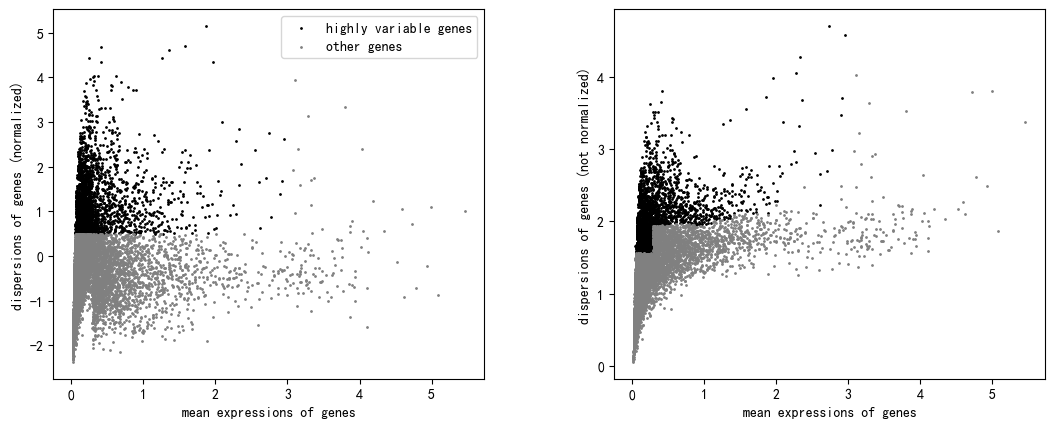

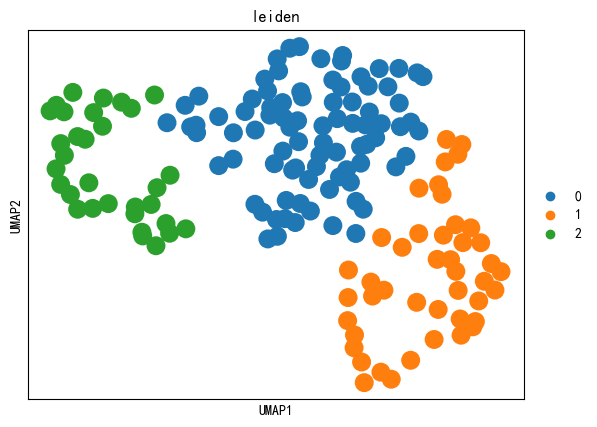

556 genes have been selected as marker genes.
Use GPU as device. cuda:1
******************************************
Epoch 1/3000 loss_train: 0.1972 loss_val: 0.1958	Test loss= 0.2853	rmse=4.5353	time: 2.6116s
******************************************
Epoch 6/3000 loss_train: 0.0928 loss_val: 0.0908	Test loss= 0.2245	rmse=4.0020	time: 2.9583s
******************************************
Epoch 11/3000 loss_train: 0.0659 loss_val: 0.0651	Test loss= 0.2197	rmse=3.9282	time: 3.0818s
******************************************
Epoch 16/3000 loss_train: 0.0479 loss_val: 0.0478	Test loss= 0.2028	rmse=3.7557	time: 3.2027s
******************************************
Epoch 21/3000 loss_train: 0.0391 loss_val: 0.0392	Test loss= 0.1864	rmse=3.5923	time: 3.3246s
******************************************
Epoch 26/3000 loss_train: 0.0355 loss_val: 0.0359	Test loss= 0.1743	rmse=3.4826	time: 3.4476s
******************************************
Epoch 31/3000 loss_train: 0.0337 loss_val: 0.0343	Test loss= 0.16

Plotting pie plots::   0%|          | 0/161 [00:00<?, ?it/s]

Plotting cell type scatter plot::   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
# for spot_num in list(range(2000,42000,2000)):
for spot_num in [10000]:
    # for seed in [10,20,30,40,50,60,70,80,90,100]:
    for seed in [20]:
        print('====>spot num:{0}, seed:{1}'.format(spot_num, seed))
        # stereo/zebrafish
        is_add_edge = True
        GCN_device = 'cuda:1'        
        prefix = 'zebrafish'
        res = 50
        idx1 = 'time12_slice8'
        dataset = '{0}_{1}'.format(prefix,idx1)
        pseudo_spot_paras['spot_num'] = spot_num

        paths = {
            'sc_path': './benchmark_data/stereo_seq/zebrafish/sc_data/{0}_{1}_sc_data.tsv'.format(prefix,idx1),
            'sc_label_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/{0}_{1}_sc_label.tsv'.format(prefix,idx1),
            'ST_path': './benchmark_data/stereo_seq/zebrafish/ST_data/{0}_{1}_data_{2}.tsv'.format(prefix,res,idx1),
            'coordinates_path' : './benchmark_data/stereo_seq/zebrafish/ST_data/{0}_{1}_coordinates_{2}.csv'.format(prefix,res,idx1),
            'groundtruth_path' : './benchmark_data/stereo_seq/zebrafish/ST_data/{0}_{1}_ground_truth_{2}.tsv'.format(prefix,res,idx1),
            'marker_genes_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/marker_genes_{}.tsv'.format(seed),
            'pseudo_spots_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/pseudo_spots/pseudo_ST_{0}_{1}_{2}_{3}_{4}.pkl'.format(
                                    pseudo_spot_paras['spot_num'], pseudo_spot_paras['min_cell_num_in_spot'], pseudo_spot_paras['max_cell_num_in_spot'], 
                                    pseudo_spot_paras['max_cell_types_in_spot'], seed),
            'topic_path' : './benchmark_data/stereo_seq/zebrafish/sc_data/topic/{}'.format(seed),
            'output_path' : './output_stereo/{}_{}/GAT'.format(prefix, idx1), 
            # 'predict_path':'./output_MERFISH/ID1/Bregma0.01/predict_result_{0}_{1}.csv'.format(idx2, pseudo_spot_paras['spot_num']),
            'metric_path' : './benchmark/metric_GAT_edge_stereo_adapt009_select_spotnum_2GAT2head_pyG.tsv',
        }
        if is_add_edge == False:
            paths['metric_path'] = './benchmark/metric_GAT_stereo_adapt009_select_spotnum_2GAT2head_pyG.tsv'
        
        # seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN
#         is_add_edge = True
#         GCN_device = 'cuda:1'
#         prefix = 'seqFISHplus'
#         dataset = 'Dataset1_seqFISHplus_from_stdGCN'
#         pseudo_spot_paras['spot_num'] = spot_num

#         paths = {
#             'sc_path': './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/sc_data/sc_data.tsv',
#             'sc_label_path' : './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/sc_data/sc_label.tsv',
#             'ST_path': './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/ST_data/ST_data.tsv',
#             'coordinates_path' : './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/ST_data/coordinates.tsv',
#             'groundtruth_path' : './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/ST_data/ST_ground_truth.tsv',
#             'pseudo_spots_path' : './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/sc_data/pseudo_spots/pseudo_ST_{0}_{1}_{2}_{3}_{4}.pkl'.format(
#                                     pseudo_spot_paras['spot_num'], pseudo_spot_paras['min_cell_num_in_spot'], pseudo_spot_paras['max_cell_num_in_spot'], 
#                                     pseudo_spot_paras['max_cell_types_in_spot'], seed),
#             'topic_path' : './benchmark_data/seqFISH_plus/Dataset1_seqFISHplus_from_stdGCN/sc_data/topic/{}'.format(seed),
#             'output_path' : './output_seqFISH_plus/{}/GAT'.format(dataset), 
#             'metric_path' : './benchmark/metric_TopicGAT_edge_seqFISH_plus_Dataset1.tsv',
#         }
#         if is_add_edge == False:
#             paths['metric_path'] = './benchmark/metric_TopicGAT_seqFISH_plus_Dataset1.tsv'

        # Dataset2_seqFISHplus_AllenVIsp
#         is_add_edge = False
#         GCN_device = 'cuda:1'
#         deconv_method = 'GAT'
#         prefix = 'seqFishplus_Cortex'
#         res = 200
#         idx1 = 'all'
#         dataset = 'Dataset2_seqFISHplus_AllenVIsp'
#         root_path = './benchmark_data/seqFISH_plus/Dataset2_seqFISHplus_AllenVIsp' 
#         pseudo_spot_paras['spot_num'] = spot_num
#         pseudo_spot_flag = '{}_{}_{}'.format( pseudo_spot_paras['min_cell_num_in_spot'], 
#                                               pseudo_spot_paras['max_cell_num_in_spot'], 
#                                               pseudo_spot_paras['max_cell_types_in_spot'] )

#         paths = {
#             'sc_path': os.path.join(root_path, 'sc_data', 'sc_data.tsv'),
#             'sc_label_path' : os.path.join(root_path, 'sc_data', 'sc_label.tsv'),
#             'ST_path': os.path.join(root_path, 'ST_data', '{0}_{1}_data_{2}.tsv'.format(prefix,res,idx1)),
#             'coordinates_path' : os.path.join(root_path, 'ST_data', '{0}_{1}_coordinates_{2}.tsv'.format(prefix,res,idx1)),
#             'groundtruth_path' : os.path.join(root_path, 'ST_data', '{0}_{1}_ground_truth_{2}.tsv'.format(prefix,res,idx1)),
#             'pseudo_spots_path' : os.path.join(root_path, 'sc_data/pseudo_spots/pseudo_ST_{0}_{1}_{2}.pkl'.format(pseudo_spot_paras['spot_num'], 
#                                                                                                                           pseudo_spot_flag, 
#                                                                                                                           seed)),
#             'topic_path' : os.path.join(root_path, 'sc_data/topic/{}'.format(seed)),
#             'output_path' : './output_seqFISH_plus/{0}/{1}/{2}'.format(dataset, deconv_method, pseudo_spot_flag), 
#             'metric_path' : './benchmark/metric_{1}_edge_{2}_seqFISH_plus_{0}.tsv'.format(dataset, deconv_method, pseudo_spot_flag)
#         }                              
#         if is_add_edge == False:
#             paths['metric_path'] = './benchmark/metric_{1}_{2}_seqFISH_plus_{0}_adapt001.tsv'.format(dataset, deconv_method, pseudo_spot_flag)

            
        
        run_TopicGAT_edge(paths,
                          load_test_groundtruth = True,
                          use_marker_genes = True,
                          external_genes = False,
                          find_marker_genes_paras = find_marker_genes_paras,
                          generate_new_pseudo_spots = False, 
                          pseudo_spot_paras = pseudo_spot_paras,
                          data_normalization_paras = data_normalization_paras,
                          integration_for_adj_paras = integration_for_adj_paras,
                          inter_exp_adj_paras = inter_exp_adj_paras,
                          spatial_adj_paras = spatial_adj_paras,
                          real_intra_exp_adj_paras = real_intra_exp_adj_paras,
                          pseudo_intra_exp_adj_paras = pseudo_intra_exp_adj_paras,
                          integration_for_feature_paras = integration_for_feature_paras,
                          GAT_paras = GAT_paras,
                          fraction_pie_plot = False,
                          cell_type_distribution_plot = False,
                          n_jobs = 24,
                          GCN_device = GCN_device,
                          seed = seed,
                          is_add_edge = is_add_edge,
                          dataset = dataset
                         )

In [24]:
from torch_geometric.nn import GCNConv
model = GATConv(1,1,1)

In [25]:
x = torch.tensor([[1.],[2.],[3.]])
adj =torch.tensor([[1, 0, 2], [0,0,1]])
model(x, adj)

tensor([[-1.4013],
        [-2.2493],
        [-2.5992]], grad_fn=<AddBackward0>)